In [1]:
#Jump to: Maximizing/Matching CONTROL
 #or: Maximizing/Matching SOCIAL  

import csv
import pandas as pd
import numpy as np
import glob
import matplotlib
import scipy as sp
from matplotlib import pyplot as plt
from itertools import cycle, islice
from scipy import stats
from datetime import datetime

import seaborn as sns

-plot score for 50 and 20 intervals 


-removing 1st trials?
-RT
-questionnaire
-JSD for max/match
-win-stay, lose-switch

9/25
need to:

1. look into c07 (key error 399): need to code first 3 trials
2. compare 100, 200, 300 timestamps
4. write script to add probabilities to hand coded df 
5. work on reaction time analyses
    import timestamps from hand coded files 
7. hand code first 3 trials of c07 and add to analyses 

This notebook is for analyzing behavior data in the social multi-armed bandit (SMAB) paradigm.
It uses Pandas dataframes (https://pandas.pydata.org/docs/getting_started/index.html#getting-started).
The 's' datasets are single-player sessions from SMAB3 and the 'j' datasets are multi-player sessions from SMAB3.
The 'c' datasets are single-player sessions from SMAB4 and the 'm' datasets are multi-player sessions from SMAB4.

Updated by Bar Y. 8/4/20

In [2]:
'''
These functions import csv files into pandas dataframes and rename the columns.
input: filename of the csv file to import; the path needs to be included, as well
output: pandas dataframe

There are multiple iterations of this function because the data is in slightly different formats. 
'''


def organize_trial_by_trial(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
    #drops first 10 trials of game 1
    #remove if you want to analyze the whole session
    #df = df[20:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    #df = df.drop(['reward'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df



#0 means "next" button
#need to exclude zero?

def organize_trial_by_trial_floatclick(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"P1 score", 7:"P2 score", 8:""})
    #have 402 so need to restrict
    #df = df[20:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['type'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df



def organize_trial_by_trial_300(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"reward", 7:"time", 8:"P1 score", 9:"P2 score"})
    #df = df[20:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    #df = df.drop(['type', 'reward'], axis=1)
    df = df.drop(['type'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df

'''#used before changes were made to template
def organize_trial_by_trial_hand_code(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    #remove first row with column headings
    df = df.drop(df.index[0])
    #convert values to numbers (NEED TO FIX)
    df.reset_index(drop=True,inplace=True)
    df = df.drop(range(0, 8))
    df.reset_index(drop=True,inplace=True)
    #df = df.apply(pd.to_numeric)
    #add column headings
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward",6:"time",7:"P1 score", 8:"P2 score"})
    df.head()
    
    return df'''

#use this function for hand coded game data files 
def organize_trial_by_trial_hand_code2(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    #remove first row with column headings
    df = df.drop(df.index[0])
    #convert values to numbers (NEED TO FIX)
    df.reset_index(drop=True,inplace=True)
    df = df.drop(range(0, 8))
    df.reset_index(drop=True,inplace=True)
    #drop comment columns
    #df = df.drop(range(7,9), axis = 1)
    #add p1 and p2 score columns
    df.insert
    #add column headings
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward",6:"time",7:"comment 1", 8:"comment 2", 9:"P1 score", 10:"P2 score"})
    
    #remove the time and comment columns (we'll add them back in a moment)
    #we are removing them bc we are converting all the values to numbeic and this can't be done to these columns
    time = df['time']
    df = df.drop('time', axis = 1 )
    
    comment_1 = df['comment 1']
    comment_2 = df['comment 2']
    df = df.drop('comment 1', axis = 1 )
    df = df.drop('comment 2', axis = 1 )
    
    df = df.apply(pd.to_numeric)
    
    #add dropped columns back in
    df['time'] = time
    df['comment 1'] = comment_1
    df['comment 2'] = comment_2
    
    #convert time and comment 1 to date time objects
    df['time']= pd.to_datetime(df['time'], errors = 'coerce', format = '%M:%S.%f')
    df['comment 1']= pd.to_datetime(df['comment 1'], errors = 'coerce', format = '%M:%S.%f')

    df.head()
    
    return df

In [3]:
'''
This function returns the score for game 1 and game 2. call_get_score can be used to call this function.
To section trials into groups of 50 or 20, change row #.
'''
def get_score(df, player_number, game_number):
    if game_number == 1:
        row = 199
    elif game_number == 2:
        row = 399
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

'''Here we get the score at trial 50 of both games'''
def get_score_at_50(df, player_number, game_number):
    if game_number == 1:
        row = 99
    elif game_number == 2:
        row = 299
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

In [4]:
#create a dataframes for scores
scores = pd.DataFrame(columns=['s_g1','s_g2','c_g1','c_g2', 'j_g1', 'j_g2', 'm_g1', 'm_g2'])

'''This function calls get_score.
input: dataframe with game data and version*
output: scores for each player and each game**
*version is 's' for single player SMAB3, 'c' for single player SMAB4, 'j' for multiplayer SMAB3, 
'm' for multiplayer SMAB4
**only 1 player score is outputted for each game in the single player sessions, while scores for both players are 
outputted for multiplayer sessions'''
def call_get_score(df, version):
    p1_g1 = get_score(df, 1, 1)
    p1_g2 = get_score(df, 1, 2)
    p1_score_diff = p1_g2 - p1_g1
    
    p1_g1_50 = get_score_at_50(df, 1, 1)
    p1_g2_50 = get_score_at_50(df, 1, 2)
    
    if version == 'j' or version == 'm':
        p1_g1 = get_score(df, 1, 1)
        p1_g2 = get_score(df, 1, 2)
        p1_score_diff = p1_g2 - p1_g1
        
        p1_g1_50 = get_score_at_50(df, 1, 1)
        p1_g2_50 = get_score_at_50(df, 1, 2)
        
        p2_g1 = get_score(df, 2, 1)
        p2_g2 = get_score(df, 2, 2)
        p2_score_diff = p2_g2 - p2_g1
        
        p2_g1_50 = get_score_at_50(df, 2, 1)
        p2_g2_50 = get_score_at_50(df, 2, 2)
        return p1_g1, p1_g2, p2_g1, p2_g2, p1_score_diff, p2_score_diff, p1_g1_50,p1_g2_50, p2_g1_50, p2_g2_50

    return p1_g1, p1_g2, p1_score_diff, p1_g1_50, p1_g2_50

In [5]:
'''This functions separates the dataframes by player and game.
input: dataframe with gamedata and version*
output: four dataframes separated by player and game
*same as call_get_score above'''



#separate data frames for p1 and p2 
def separate_df(df, version):
    #df.set_index(df['trial'])
    df_p1 = df[df['player'] == 1]
    df_p1_g1 = df_p1[df['game number'] == 1]
    df_p1_g2 = df_p1[df['game number'] == 2]
    
    #remove trials for g1
    df_p1_g1 = df_p1_g1[10:40]
    #remove trials for g2
    df_p1_g2 = df_p1_g2[10:40]
    
    if version == 's':
        return df_p1_g1, df_p1_g2
    if version == 'c':
        return df_p1_g1, df_p1_g2
    df_p2 = df[df['player'] ==2 ]
    df_p2_g1 = df_p2[df['game number'] == 1]
    df_p2_g2 = df_p2[df['game number'] == 2]
    
    #remove trials for g1
    df_p2_g1 = df_p2_g1[10:40]
    #remove trials for g2
    df_p2_g2= df_p2_g2[10:40]
    
    return df_p1_g1, df_p1_g2, df_p2_g1, df_p2_g2

In [6]:
#ignore for now
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [7]:
'''This function separates reaction times into post-win and post-loss arrays.
NOTE that it is intended to be called with dataframes separated by separate_df (ex. s01_p1_g1)'''
def reaction_time(df, time):
    df.reset_index(drop=True, inplace=True)
    post_win_time = []
    post_loss_time = []
    for index, row in df.iterrows():
        if index > 0 and index < 101:
            prev_rew = df.loc[index - 1, 'reward']
            if prev_rew == 1:
                post_win_time.append(df.loc[index, 'time'])
            elif prev_rew == 0:
                post_loss_time.append(df.loc[index, 'time'])
    post_win_mean = np.mean(post_win_time)
    post_loss_mean = np.mean(post_loss_time)
    name = str(get_df_name(df))
    time = time.append({'session' : name , 'post win' : post_win_mean, 'post loss': post_loss_mean} , ignore_index=True)
    return(time)

In [8]:
'''This functionfixes the reward column in the files imported using the '300' function. 
This function works for dataframes that have already been split up by game and player by separate_df (ex. c12_p1_g1)
NOTE that this function had to be written for a subset of the data that had a bug that caused the reward column to be
0 for all trials.'''
def fix_reward(df):
    df.reset_index(drop=True, inplace=True)
    for index, row in df.iterrows():
        if df.loc[index, 'player'] == 1:
                score_column = 'P1 score'
        elif df.loc[index, 'player'] == 2:
                score_column = 'P2 score'
        if index == 0:
            if df.loc[index, score_column] == 1:
                df.loc[index, 'reward'] = 1
            #not necessary here because the values are all 0
            else:
                df.loc[index, 'reward'] = 0
        elif index > 0:
            prev_score = df.loc[index - 1, score_column]
            curr_score = df.loc[index, score_column]
            score_diff = curr_score - prev_score
            df.loc[index, 'reward'] = score_diff
    return(df)

In [9]:
'''This function outputs the hole-probability mappings in each game. 
input: df of session data
output: df with the hole-probability mappings
g = game
p = player
h = hole
r = reward (1 means yes and 0 means no)
'''

def hole_prob_map(df):
    h1_prob = df.loc[df['arm'] == 1, 'probability'].iloc[0]
    h2_prob = df.loc[df['arm'] == 2, 'probability'].iloc[0]
    h3_prob = df.loc[df['arm'] == 3, 'probability'].iloc[0]
    h_probs = pd.DataFrame({'h1_prob': [h1_prob], 'h2_prob': [h2_prob], 'h3_prob': [h3_prob]})
    
    return h_probs


In [10]:
'''Here we compare the choice distributions to idealized models of two decision-making strategies: 
matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
and maximizing would be always choosing the high reward hole.'''

#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://urldefense.com/v3/__https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX94Xg7JRI$ . *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://urldefense.com/v3/__https://en.wikipedia.org/wiki/Jensen**BShannon_divergence__;4oCT!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9SSBIvMc$ 
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.



#Idealized probability distributions to use for comparison. You can change these or add more models.

maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,90/180 * 100]
random = [30/90 * 100,30/90 * 100,30/90 * 100]
social = [1/3 * 100,1/3 * 100, 1/3 * 100]


#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize) #(p, q)
    matchi = jsd(counts,match)
    randi = jsd(counts,random)
    soci = jsd(counts,social)
    return maxi,matchi,randi, soci

# Hand Coding Functions
These functions can be used for game data files that were created by hand coding.

In [11]:
#jsd(social,m01_p1_g1_count)

In [12]:
'''This function calculates the number of times each hole was chosen and the 
probability with which each hole rewarded each player in each game.
input: hand coded game data file in a df
output: df with the number of times each hole was chosen by each player in each game and the percentage of choices that were
rewarded
g = game
p = player
h = hole
r = reward (1 means yes and 0 means no)'''

def handcode_calc_prob(df):
    
    #NOTE: turn into function with parameters for game and player
    #get counts for g1, p1
    g1_p1_h1_r1_count,g1_p1_h1_r0_count,g1_p1_h2_r1_count,g1_p1_h2_r0_count,g1_p1_h3_r1_count,g1_p1_h3_r0_count = get_count(df, 1,1)
    
    g1_p2_h1_r1_count,g1_p2_h1_r0_count,g1_p2_h2_r1_count,g1_p2_h2_r0_count,g1_p2_h3_r1_count,g1_p2_h3_r0_count = get_count(df, 2,1)
    
    g2_p1_h1_r1_count,g2_p1_h1_r0_count,g2_p1_h2_r1_count,g2_p1_h2_r0_count,g2_p1_h3_r1_count,g2_p1_h3_r0_count = get_count(df, 1,2)
    
    g2_p2_h1_r1_count,g2_p2_h1_r0_count,g2_p2_h2_r1_count,g2_p2_h2_r0_count,g2_p2_h3_r1_count,g2_p2_h3_r0_count = get_count(df, 2,2)
    
    #calculate reward rate of each hole in each condition
    
    g1_p1_h1 = calc_prob(g1_p1_h1_r1_count,g1_p1_h1_r0_count)
    g1_p1_h2 = calc_prob(g1_p1_h2_r1_count,g1_p1_h2_r0_count)
    g1_p1_h3 = calc_prob(g1_p1_h3_r1_count,g1_p1_h3_r0_count)
    
    g1_p2_h1 = calc_prob(g1_p2_h1_r1_count,g1_p2_h1_r0_count)
    g1_p2_h2 = calc_prob(g1_p2_h2_r1_count,g1_p2_h2_r0_count)
    g1_p2_h3 = calc_prob(g1_p2_h3_r1_count,g1_p2_h3_r0_count)
    
    g2_p1_h1 = calc_prob(g2_p1_h1_r1_count,g2_p1_h1_r0_count)
    g2_p1_h2 = calc_prob(g2_p1_h2_r1_count,g2_p1_h2_r0_count)
    g2_p1_h3 = calc_prob(g2_p1_h3_r1_count,g2_p1_h3_r0_count)
    
    g2_p2_h1 = calc_prob(g2_p2_h1_r1_count,g2_p2_h1_r0_count)
    g2_p2_h2 = calc_prob(g2_p2_h2_r1_count,g2_p2_h2_r0_count)
    g2_p2_h3 = calc_prob(g2_p2_h3_r1_count,g2_p2_h3_r0_count)
    
    
    #NEED to add indices to these
    p1_counts_d = {'g1_p1_h1_count': [g1_p1_h1_r1_count, g1_p1_h1_r0_count], 'g1_p1_h2_count': [g1_p1_h2_r1_count, g1_p1_h2_r0_count],
        'g1_p1_h3_count': [g1_p1_h3_r1_count, g1_p1_h3_r0_count], 'g2_p1_h1_count': [g2_p1_h1_r1_count, g2_p1_h1_r0_count], 
         'g2_p1_h2_count': [g2_p1_h2_r1_count, g2_p1_h2_r0_count],
        'g2_p1_h3_count': [g2_p1_h3_r1_count, g2_p1_h3_r0_count] }
    p1_counts_df = pd.DataFrame(p1_counts_d)
    
    p2_counts_d = {'g1_p2_h1_count': [g1_p2_h1_r1_count, g1_p2_h1_r0_count], 'g1_p2_h2_count': [g1_p2_h2_r1_count, g1_p2_h2_r0_count],
        'g1_p2_h3_count': [g1_p2_h3_r1_count, g1_p2_h3_r0_count], 'g2_p2_h1_count': [g2_p2_h1_r1_count, g2_p2_h1_r0_count], 
         'g2_p2_h2_count': [g2_p2_h2_r1_count, g2_p2_h2_r0_count],
        'g2_p2_h3_count': [g2_p2_h3_r1_count, g2_p2_h3_r0_count] }
    p2_counts_df = pd.DataFrame(p2_counts_d)
    
    p1_counts_df.index = ['rewarded', 'non-rewarded']
    p2_counts_df.index = ['rewarded','non-rewarded']
    
    p1_probs_d = {'p1_h1':[g1_p1_h1, g2_p1_h1], 'p1_h2':[g1_p1_h2, g2_p1_h2], 'p1_h3':[g1_p1_h3, g2_p1_h3]}
    p1_probs_df = pd.DataFrame(p1_probs_d)
    
    p2_probs_d = {'p2_h1':[g1_p2_h1, g2_p2_h1], 'p1_h2':[g1_p2_h2, g2_p2_h2], 'p1_h3':[g1_p2_h3, g2_p2_h3]}
    p2_probs_df = pd.DataFrame(p2_probs_d)
    
    p1_probs_df.index = ['game 1', 'game 2'] 
    p2_probs_df.index = ['game 1','game 2']
    
    return p1_counts_df, p2_counts_df, p1_probs_df, p2_probs_df


In [13]:
'''This function is called in handcode_calc_prob and calculates the number of times each hole was chosen and rewarded/not rewarded
input: df, player and game numbers
output: counts for each hole and outcome (rewarded/not rewarded)
'''
def get_count(df,player,game):
    h1_r1_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==1) & (df['reward']==1)])
    h1_r0_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==1) & (df['reward']==0)])
    h2_r1_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==2) & (df['reward']==1)])
    h2_r0_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==2) & (df['reward']==0)])
    h3_r1_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==3) & (df['reward']==1)])
    h3_r0_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==3) & (df['reward']==0)])
    return h1_r1_count, h1_r0_count, h2_r1_count, h2_r0_count, h3_r1_count, h2_r0_count

In [14]:
'''This function is called in handcode_calc_prob and calculates the reward probability of a hole.
input: number of rewarded trials, number of un-rewarded trials
output: percentage of rewarded trials for that hole'''
def calc_prob(r1,r0):
    try:
        return (r1/(r1+r0) * 100)
    #if the hole was never chosen and the denominator is 0
    except ZeroDivisionError:
        return 0

In [15]:
'''This function fills in the dataframe with the probabilities (30, 60, or 90) to each hole for each player in each
game.
input: dataframe with gamedata, probabilities for each player/game number/hole*
output: dataframe with the probabilities filled in
*You must put the inputs in the correct order as defined in the parameters of the function.
'''
def fill_in_prob(df, p1_g1_h1, p1_g1_h2, p1_g1_h3, p1_g2_h1, p1_g2_h2, p1_g2_h3, p2_g1_h1, p2_g1_h2, p2_g1_h3, 
                 p2_g2_h1, p2_g2_h2, p2_g2_h3):
    for index, row in df.iterrows():
        if df.loc[index,'game number'] == 1:
            if df.loc[index,'player'] == 1:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p1_g1_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p1_g1_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p1_g1_h3
            elif df.loc[index,'player'] == 2:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p2_g1_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p2_g1_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p2_g1_h3
        elif df.loc[index,'game number'] == 2:
            if df.loc[index,'player'] == 1:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p1_g2_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p1_g2_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p1_g2_h3
            elif df.loc[index,'player'] == 2:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p2_g2_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p2_g2_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p2_g2_h3
    return df

# SMAB3 Single Player Analysis

In [16]:
'''
Here, we load all of the csv files into pandas dataframes using organize_trial_by_trial and get the game 1 and 2 scores using 
call_get_score.'''

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s01_gamedata.csv')
s01 = df
s01_p1_g1_score,s01_p1_g2_score,s01_score_diff,s01_p1_g1_50,s01_p1_g2_50 = call_get_score(s01, 's')
s01.head()

''''#in the s files, p2 is the confederate- NEED TO WORK ON
df = organize_trial_by_trial('data/s02_gamedata.csv')
s02 = df
s02_p1_g1_score = get_score(s02, 1, 1)
s02_p1_g1_score,s02_p1_g2_score,s02_score_diff,s02_p1_g1_50,s02_p1_g2_50 = call_get_score(s02, 's')
s02.head()'''


#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s03_gamedata.csv')
s03 = df
s03_p1_g1_score,s03_p1_g2_score,s03_score_diff,s03_p1_g1_50,s03_p1_g2_50 = call_get_score(s03, 's')
s03.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s05_gamedata.csv')
s05 = df
s05_p1_g1_score,s05_p1_g2_score,s05_score_diff, s05_p1_g1_50,s05_p1_g2_50 = call_get_score(s05, 's')
s05.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s06_gamedata.csv')
s06 = df
s06_p1_g1_score,s06_p1_g2_score,s06_score_diff, s06_p1_g1_50,s06_p1_g2_50 = call_get_score(s06, 's')
s06.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s07_gamedata.csv')
s07 = df
s07_p1_g1_score,s07_p1_g2_score,s07_score_diff, s07_p1_g1_50,s07_p1_g2_50 = call_get_score(s07, 's')
s07.head()

pd.set_option('display.max_columns', None)  

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s08_gamedata.csv')
s08 = df
s08_p1_g1_score,s08_p1_g2_score,s08_score_diff, s08_p1_g1_50,s08_p1_g2_50 = call_get_score(s08, 's')
s08.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s09_gamedata.csv')
s09 = df
s09_p1_g1_score,s09_p1_g2_score,s09_score_diff, s09_p1_g1_50,s09_p1_g2_50 = call_get_score(s09, 's')
s09.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s11_gamedata2.csv')
s11 = df
s11_p1_g1_score,s11_p1_g2_score,s11_score_diff,s11_p1_g1_50,s11_p1_g2_50 = call_get_score(s11, 's')
s11.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s12_gamedata.csv')
s12 = df
s12_p1_g1_score,s12_p1_g2_score,s12_score_diff, s12_p1_g1_50,s12_p1_g2_50 = call_get_score(s12, 's')
s12.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_hand_code2('data/s14_gamedata_handcode.csv')
s14 = df
#s12_p1_g1_score,s12_p1_g2_score,s12_score_diff, s12_p1_g1_50,s12_p1_g2_50 = call_get_score(s12, 's')
s14.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s15_gamedata2.csv')
s15 = df
s15_p1_g1_score,s15_p1_g2_score,s15_score_diff,s15_p1_g1_50,s15_p1_g2_50 = call_get_score(s15, 's')
s15.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s16_gamedata2.csv')
s16 = df
s16_p1_g1_score,s16_p1_g2_score,s16_score_diff,s16_p1_g1_50,s16_p1_g2_50 = call_get_score(s16, 's')
s16.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s19_gamedata.csv')
s19 = df
s19_p1_g1_score,s19_p1_g2_score,s19_score_diff,s19_p1_g1_50,s19_p1_g2_50 = call_get_score(s19, 's')
s19.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s17_gamedata2.csv')
s17 = df
s17_p1_g1_score,s17_p1_g2_score,s17_score_diff,s17_p1_g1_50,s17_p1_g2_50 = call_get_score(s17, 's')
s17.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s20_gamedata.csv')
s20 = df
s20_p1_g1_score,s20_p1_g2_score,s20_score_diff, s20_p1_g1_50,s20_p1_g2_50= call_get_score(s20, 's')
s20.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,1,90,0,0
1,1,1,2,0,90,1,0
2,1,2,1,2,60,1,1
3,1,2,2,0,90,2,1
4,1,3,1,3,30,2,2


In [17]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s17_gamedata2.csv')
s17 = df
s17_p1_g1_score,s17_p1_g2_score,s17_score_diff,s17_p1_g1_50,s17_p1_g2_50 = call_get_score(s17, 's')
s17.head()

,game number,trial,player,arm,probability,reward,time,P1 score,P2 score
0,1,1,1,2,90,1,25.633740,1,0
1,1,1,2,1,90,1,10.289090,1,1
2,1,2,1,3,60,0,5.244492,1,1
3,1,2,2,1,90,1,13.060750,1,2
4,1,3,1,2,90,1,2.117987,2,2


In [18]:
s14_p1_counts, s14_p2_counts, s14_p1_probs, s14_p2_probs = handcode_calc_prob(s14)

In [19]:
'''The Hand Code Functions are called for s14'''
s14 = fill_in_prob(s14, 60,90,30,60,90,30,60,90,30,60,90,30)
s14_p1_g1, s14_p1_g2 = separate_df(s14, 'c')
s14_p1_g1_score = s14_p1_g1['reward'].sum()
s14_p1_g2_score = s14_p1_g2['reward'].sum()

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [20]:
'''
Here, we create a dataframe of all of the scores and score differences between game 1 and 2'''

#list out all the scores in game 1 by participant
s_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's14','s15', 's16', 's17', 's19', 's20'], 'score':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s14_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score]})
#to prevent an extra column that numbers each row:
s_scores_1.set_index('participant', inplace=True, drop=True)

#game 2 data is split by same (s) and different (d) contingencies in g1 and g2
#list out all the scores in game 2 by participant
s_scores_2_d = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09',], 'score':
    [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score]})

#to prevent an extra column that numbers each row:
s_scores_2_d.set_index('participant', inplace=True, drop=True)

s_scores_2_s = pd.DataFrame({'participant':['s11', 's12', 's14','s15', 's16', 's17', 's19', 's20'], 'score':
    [s11_p1_g2_score, s12_p1_g2_score, s14_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score]})

#to prevent an extra column that numbers each row:
s_scores_2_s.set_index('participant', inplace=True, drop=True)


#list out all the scores in game 1 by participant
s_scores_1_50 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_1_50':
     [s01_p1_g1_50, s03_p1_g1_50, s05_p1_g1_50,
      s06_p1_g1_50, s07_p1_g1_50, s08_p1_g1_50, s09_p1_g1_50, s11_p1_g1_50, s12_p1_g1_50, s15_p1_g1_50, s16_p1_g1_50, s17_p1_g1_50, s19_p1_g1_50, s20_p1_g1_50]})
#to prevent an extra column that numbers each row:
s_scores_1_50.set_index('participant', inplace=True, drop=True)

#list out all the scores in game 2 by participant
s_scores_2_50 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_2_50':
    [s01_p1_g2_50, s03_p1_g2_50, s05_p1_g2_50, 
s06_p1_g2_50, s07_p1_g2_50, s08_p1_g2_50, s09_p1_g2_50, s11_p1_g2_50, s12_p1_g2_50, s15_p1_g2_50, s16_p1_g2_50, s17_p1_g2_50, s19_p1_g2_50, s20_p1_g2_50]})
s_scores_2_50.set_index('participant', inplace=True, drop=True)

#frames = [s_scores_1_50,s_scores_2_50,s_scores_1,s_scores_2]'''

"\n#merge both games by participant:\ns_scores = pd.merge(s_scores_1, s_scores_2,on='participant')\n\n#label columns\ns_scores.columns=['Game 1','Game 2']\n\ns_scores"

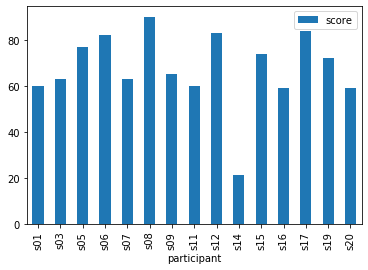

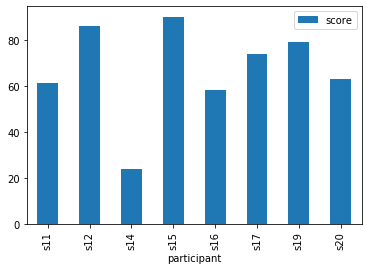

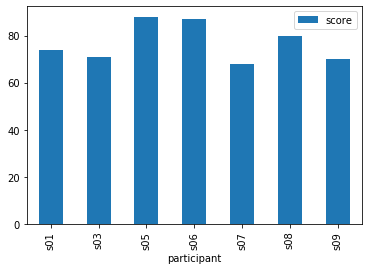

In [21]:
'''Here we plot the scores.'''

s_scores_1_bar = s_scores_1.plot.bar()

s_scores_2_s_bar = s_scores_2_s.plot.bar()

s_scores_2_d_bar = s_scores_2_d.plot.bar()

'''
#merge both games by participant:
s_scores = pd.merge(s_scores_1, s_scores_2,on='participant')

#label columns
s_scores.columns=['Game 1','Game 2']

s_scores'''

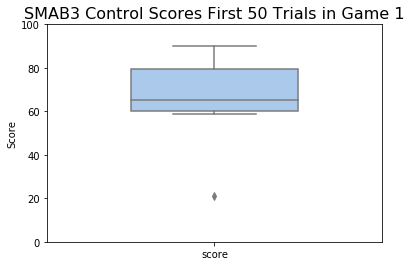

In [22]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores1_box = sns.boxplot( 
                 data=s_scores_1,
                 width=0.5,
                 palette="pastel")
s_scores1_box.axes.set_title("SMAB3 Control Scores First 50 Trials in Game 1",
                    fontsize=16)

plot_file_name="s_score1_box.jpg"
 
plt.ylim(0, 100)
s_scores1_box.axes.set(ylabel='Score')

# save as jpeg
s_scores1_box.figure.savefig(plot_file_name,
                    format='jpeg')

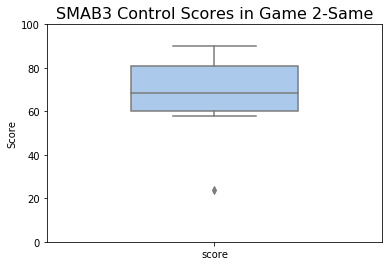

In [23]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores2s_box = sns.boxplot( 
                 data=s_scores_2_s,
                 width=0.5,
                 palette="pastel")
s_scores2s_box.axes.set_title("SMAB3 Control Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="s_score_2s_box.jpg"
 
plt.ylim(0, 100)
s_scores2s_box.axes.set(ylabel='Score')

# save as jpeg
s_scores2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

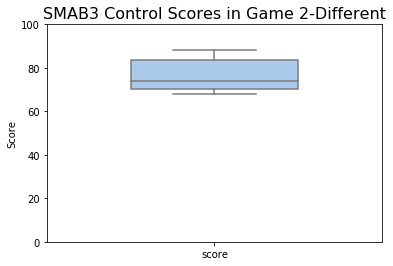

In [24]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores2d_box = sns.boxplot( 
                 data=s_scores_2_d,
                 width=0.5,
                 palette="pastel")
s_scores2d_box.axes.set_title("SMAB3 Control Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="s_score_2d_box.jpg"
 
plt.ylim(0, 100)
s_scores2d_box.axes.set(ylabel='Score')

# save as jpeg
s_scores2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [25]:
#SMAB3 CONTROL SCORES
'''Here we look at the means, standard deviations, and medians of the scores in games 1 and 2.'''

s_scores_1_mean = s_scores_1.mean()

In [26]:
s_scores_1_std = s_scores_1.std()

In [27]:
s_scores_1_mean, s_scores_1_std

(score    67.466667
 dtype: float64, score    16.578242
 dtype: float64)

In [28]:
s_scores_2s_mean = s_scores_2_s.mean()

In [29]:
s_scores_2s_std = s_scores_2_s.std()

In [30]:
s_scores_2d_mean = s_scores_2_d.mean()

In [31]:
s_scores_2d_std = s_scores_2_d.std()

In [32]:
s_scores_2s_mean, s_scores_2s_std

(score    66.875
 dtype: float64, score    20.92461
 dtype: float64)

In [33]:
s_scores_2d_mean, s_scores_2d_std

(score    76.857143
 dtype: float64, score    8.214389
 dtype: float64)

In [34]:
sp.stats.ttest_ind(s_scores_2_s, s_scores_2_d)

Ttest_indResult(statistic=array([-1.18058121]), pvalue=array([0.25891973]))

In [35]:
'''Here we separate the dataframes of game 1 and game 2 for each subject.'''


s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
s03_p1_g1, s03_p1_g2 = separate_df(s03, 's')
s05_p1_g1, s05_p1_g2 = separate_df(s05, 's')
s06_p1_g1, s06_p1_g2 = separate_df(s06, 's')
s07_p1_g1, s07_p1_g2 = separate_df(s07, 's')
s08_p1_g1, s08_p1_g2 = separate_df(s08, 's')
s09_p1_g1, s09_p1_g2 = separate_df(s09, 's')
s11_p1_g1, s11_p1_g2 = separate_df(s11, 's')
s12_p1_g1, s12_p1_g2 = separate_df(s12, 's')
s15_p1_g1, s15_p1_g2 = separate_df(s15, 's')
s16_p1_g1, s16_p1_g2 = separate_df(s16, 's')
s17_p1_g1, s17_p1_g2 = separate_df(s17, 's')
s19_p1_g1, s19_p1_g2 = separate_df(s19, 's')
s20_p1_g1, s20_p1_g2 = separate_df(s20, 's')

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [36]:
'''Here we check the arm-probability mappings in each game'''
#IndexError: single positional indexer is out-of-bounds
'''s01_p1_g1_map = hole_prob_map(s01_p1_g1)
s01_p1_g2_map = hole_prob_map(s01_p1_g2)

s03_p1_g1_map = hole_prob_map(s03_p1_g1)
s03_p1_g2_map = hole_prob_map(s03_p1_g2)

s05_p1_g1_map = hole_prob_map(s05_p1_g1)
#s05_p1_g2_map = hole_prob_map(s05_p1_g2)

s07_p1_g1_map = hole_prob_map(s07_p1_g1)
s07_p1_g2_map = hole_prob_map(s07_p1_g2)

s08_p1_g1_map = hole_prob_map(s08_p1_g1)
s08_p1_g2_map = hole_prob_map(s08_p1_g2)

s09_p1_g1_map = hole_prob_map(s09_p1_g1)
s09_p1_g2_map = hole_prob_map(s09_p1_g2)

s11_p1_g1_map = hole_prob_map(s11_p1_g1)
s11_p1_g2_map = hole_prob_map(s11_p1_g2)

s12_p1_g1_map = hole_prob_map(s12_p1_g1)
s12_p1_g2_map = hole_prob_map(s12_p1_g2)

s15_p1_g1_map = hole_prob_map(s15_p1_g1)
s15_p1_g2_map = hole_prob_map(s15_p1_g2)

s16_p1_g1_map = hole_prob_map(s16_p1_g1)
s16_p1_g2_map = hole_prob_map(s16_p1_g2)

s17_p1_g1_map = hole_prob_map(s17_p1_g1)
#s17_p1_g2_map = hole_prob_map(s17_p1_g2)'''

's01_p1_g1_map = hole_prob_map(s01_p1_g1)\ns01_p1_g2_map = hole_prob_map(s01_p1_g2)\n\ns03_p1_g1_map = hole_prob_map(s03_p1_g1)\ns03_p1_g2_map = hole_prob_map(s03_p1_g2)\n\ns05_p1_g1_map = hole_prob_map(s05_p1_g1)\n#s05_p1_g2_map = hole_prob_map(s05_p1_g2)\n\ns07_p1_g1_map = hole_prob_map(s07_p1_g1)\ns07_p1_g2_map = hole_prob_map(s07_p1_g2)\n\ns08_p1_g1_map = hole_prob_map(s08_p1_g1)\ns08_p1_g2_map = hole_prob_map(s08_p1_g2)\n\ns09_p1_g1_map = hole_prob_map(s09_p1_g1)\ns09_p1_g2_map = hole_prob_map(s09_p1_g2)\n\ns11_p1_g1_map = hole_prob_map(s11_p1_g1)\ns11_p1_g2_map = hole_prob_map(s11_p1_g2)\n\ns12_p1_g1_map = hole_prob_map(s12_p1_g1)\ns12_p1_g2_map = hole_prob_map(s12_p1_g2)\n\ns15_p1_g1_map = hole_prob_map(s15_p1_g1)\ns15_p1_g2_map = hole_prob_map(s15_p1_g2)\n\ns16_p1_g1_map = hole_prob_map(s16_p1_g1)\ns16_p1_g2_map = hole_prob_map(s16_p1_g2)\n\ns17_p1_g1_map = hole_prob_map(s17_p1_g1)\n#s17_p1_g2_map = hole_prob_map(s17_p1_g2)'

In [37]:
s01_p1_g1

,game number,trial,player,arm,probability,reward,time,P1 score,P2 score
20,1,11,1,3,60,0,2.506092,5,10
22,1,12,1,3,60,1,2.129512,6,11
24,1,13,1,3,60,1,2.859897,7,12
26,1,14,1,1,90,1,2.659386,8,13
28,1,15,1,3,60,1,2.522157,9,14
30,1,16,1,3,60,1,2.403007,10,15
32,1,17,1,2,30,0,2.331370,10,16
34,1,18,1,2,30,1,1.615854,11,17
36,1,19,1,3,60,0,2.721275,11,18
38,1,20,1,3,60,1,1.528131,12,19


In [38]:
s01_p1_g2


,game number,trial,player,arm,probability,reward,time,P1 score,P2 score
220,2,11,1,3,30,0,2.537525,7,8
222,2,12,1,3,30,0,3.240973,7,9
224,2,13,1,2,90,1,3.199889,8,10
226,2,14,1,1,60,1,3.057177,9,11
228,2,15,1,2,90,1,2.776664,10,12
230,2,16,1,3,30,1,3.064561,11,13
232,2,17,1,2,90,1,3.593238,12,14
234,2,18,1,2,90,1,2.927821,13,15
236,2,19,1,3,30,0,2.778097,13,16
238,2,20,1,1,60,0,2.553147,13,17


In [39]:
'''Here we count the number of times that each hole was selected by each subject in each game by calling value_counts'''


s01_p1_g1_count = s01_p1_g1['probability'].value_counts(sort=False)
s01_p1_g2_count = s01_p1_g2['probability'].value_counts(sort=False)
s03_p1_g1_count = s03_p1_g1['probability'].value_counts(sort=False)
s03_p1_g2_count = s03_p1_g2['probability'].value_counts(sort=False)
s05_p1_g1_count = s05_p1_g1['probability'].value_counts(sort=False)
s05_p1_g2_count = s05_p1_g2['probability'].value_counts(sort=False)
s06_p1_g1_count = s06_p1_g1['probability'].value_counts(sort=False)
s06_p1_g2_count = s06_p1_g2['probability'].value_counts(sort=False)
s07_p1_g1_count = s07_p1_g1['probability'].value_counts(sort=False)
s07_p1_g2_count = s07_p1_g2['probability'].value_counts(sort=False)
s08_p1_g1_count = s08_p1_g1['probability'].value_counts(sort=False)
s08_p1_g2_count = s08_p1_g2['probability'].value_counts(sort=False)
s09_p1_g1_count = s09_p1_g1['probability'].value_counts(sort=False)
s09_p1_g2_count = s09_p1_g2['probability'].value_counts(sort=False)
s11_p1_g1_count = s11_p1_g1['probability'].value_counts(sort=False)
s11_p1_g2_count = s11_p1_g2['probability'].value_counts(sort=False)
s12_p1_g1_count = s12_p1_g1['probability'].value_counts(sort=False)
s12_p1_g2_count = s12_p1_g2['probability'].value_counts(sort=False)
s14_p1_g1_count = s14_p1_g1['probability'].value_counts(sort=False)
s14_p1_g2_count = s14_p1_g2['probability'].value_counts(sort=False)
s15_p1_g1_count = s15_p1_g1['probability'].value_counts(sort=False)
s15_p1_g2_count = s15_p1_g2['probability'].value_counts(sort=False)
s16_p1_g1_count = s16_p1_g1['probability'].value_counts(sort=False)
s16_p1_g2_count = s16_p1_g2['probability'].value_counts(sort=False)
s17_p1_g1_count = s17_p1_g1['probability'].value_counts(sort=False)
s17_p1_g2_count = s17_p1_g2['probability'].value_counts(sort=False)
s19_p1_g1_count = s19_p1_g1['probability'].value_counts(sort=False)
s19_p1_g2_count = s19_p1_g2['probability'].value_counts(sort=False)
s20_p1_g1_count = s20_p1_g1['probability'].value_counts(sort=False)
s20_p1_g2_count = s20_p1_g2['probability'].value_counts(sort=False)

In [40]:
#SMAB3 CONTROL COUNTS
s01_p1_g1_count

90     4
60    14
30    12
Name: probability, dtype: int64

In [41]:
s01_p1_g2_count

90    13
60     4
30    13
Name: probability, dtype: int64

In [42]:
'''Here we create dataframes with the counts for game 1.'''

s_g1_counts = pd.DataFrame([s01_p1_g1_count, s03_p1_g1_count, s05_p1_g1_count, s06_p1_g1_count, s07_p1_g1_count, 
                s08_p1_g1_count, s09_p1_g1_count, s11_p1_g1_count, s12_p1_g1_count,s14_p1_g1_count, s15_p1_g1_count, s16_p1_g1_count,
                    s17_p1_g1_count, s19_p1_g1_count, s20_p1_g1_count],
                          index=['s01_p1_g1_count', 's03_p1_g1_count', 
                            's05_p1_g1_count', 's06_p1_g1_count', 's07_p1_g1_count', 's08_p1_g1_count', 
                                 's09_p1_g1_count', 's11_p1_g1_count', 's12_p1_g1_count','s14_p1_g1_count', 's15_p1_g1_count', 
                                 's16_p1_g1_count','s17_p1_g1_count', 's19_p1_g1_count', 's20_p1_g1_count'])




#How to prevent NaN: df = df.fillna(0). This makes the value 0 if a hole was never selected by a subject.
s_g1_counts = s_g1_counts.fillna(0)

#print
s_g1_counts

,30.0,60.0,90.0
s01_p1_g1_count,12.0,14.0,4.0
s03_p1_g1_count,9.0,11.0,10.0
s05_p1_g1_count,0.0,0.0,30.0
s06_p1_g1_count,1.0,0.0,29.0
s07_p1_g1_count,10.0,11.0,9.0
s08_p1_g1_count,0.0,0.0,30.0
s09_p1_g1_count,9.0,9.0,12.0
s11_p1_g1_count,11.0,8.0,11.0
s12_p1_g1_count,4.0,14.0,12.0
s14_p1_g1_count,2.0,1.0,27.0


In [43]:
s_g1_counts.sum(axis=1)

s01_p1_g1_count    30.0
s03_p1_g1_count    30.0
s05_p1_g1_count    30.0
s06_p1_g1_count    30.0
s07_p1_g1_count    30.0
s08_p1_g1_count    30.0
s09_p1_g1_count    30.0
s11_p1_g1_count    30.0
s12_p1_g1_count    30.0
s14_p1_g1_count    30.0
s15_p1_g1_count    30.0
s16_p1_g1_count    30.0
s17_p1_g1_count    30.0
s19_p1_g1_count    30.0
s20_p1_g1_count    30.0
dtype: float64

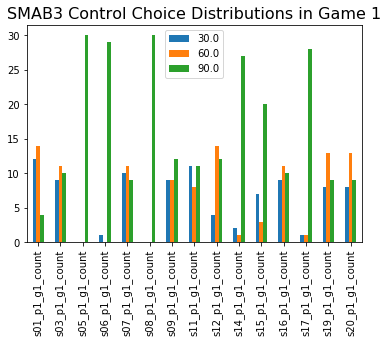

In [44]:
#Here we plot the value counts

s_g1_counts.sum(axis=1)


s_g1_counts_bar = s_g1_counts.plot.bar()

s_g1_counts_bar.axes.set_title("SMAB3 Control Choice Distributions in Game 1",
                    fontsize=16)

# save as jpeg
s_g1_counts_bar.figure.savefig("s_g1_counts_bar.jpg",
                    format='jpeg')

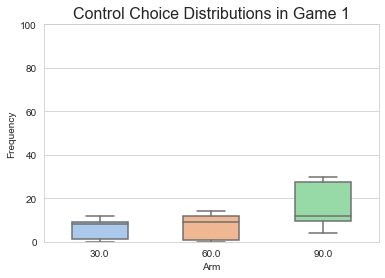

In [262]:
s_g1_counts_box = sns.boxplot( 
                 data=s_g1_counts, 
                 width=0.5,
                 palette="pastel")
s_g1_counts_box.axes.set_title("Control Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="s_g1_counts_box.jpg"
 
plt.ylim(0, 100)
s_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [46]:
'''Here we get the mean and standard deviation of the number of selections of each hole where low is the 0th column and the 30% hole, 
med is the 1st column and the 60% hole, and high is the 2nd column and the 90% hole.'''


s_g1_low = np.mean(s_g1_counts.iloc[:,0])
s_g1_med = np.mean(s_g1_counts.iloc[:,1])
s_g1_high = np.mean(s_g1_counts.iloc[:,2])


s_g1_low_std = np.std(s_g1_counts.iloc[:,0])
s_g1_med_std = np.std(s_g1_counts.iloc[:,1])
s_g1_high_std = np.std(s_g1_counts.iloc[:,2])

In [47]:
s_g1_low, s_g1_med, s_g1_high

(6.066666666666666, 7.266666666666667, 16.666666666666668)

In [48]:
 s_g1_low_std, s_g1_med_std, s_g1_high_std

(4.122566622330749, 5.519259209551788, 9.148163142887697)

In [49]:
'''Here we create dataframes with the counts for game 2.'''


s_g2_counts = pd.DataFrame([s01_p1_g2_count, s03_p1_g2_count, 
                            s05_p1_g2_count, s06_p1_g2_count, s07_p1_g2_count, s08_p1_g2_count, s09_p1_g2_count, s11_p1_g2_count, s12_p1_g2_count, s14_p1_g2_count, s15_p1_g2_count, s16_p1_g2_count,
                    s17_p1_g2_count, s19_p1_g2_count, s20_p1_g2_count],
                             index= ['s01_p1_g2_count', 's03_p1_g2_count', 's05_p1_g2_count', 's06_p1_g2_count',
                                 's07_p1_g2_count', 's08_p1_g2_count', 's09_p1_g2_count', 's11_p1_g2_count', 's12_p1_g2_count', 's14_p1_g2_count', 's15_p1_g2_count',
                                 's16_p1_g2_count', 's17_p1_g2_count', 's19_p1_g2_count', 's20_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
s_g2_counts = s_g2_counts.fillna(0)

#print
s_g2_counts

s_g2_counts.sum(axis=1)

s01_p1_g2_count    30.0
s03_p1_g2_count    30.0
s05_p1_g2_count    30.0
s06_p1_g2_count    30.0
s07_p1_g2_count    30.0
s08_p1_g2_count    30.0
s09_p1_g2_count    30.0
s11_p1_g2_count    30.0
s12_p1_g2_count    30.0
s14_p1_g2_count    30.0
s15_p1_g2_count    30.0
s16_p1_g2_count    30.0
s17_p1_g2_count    30.0
s19_p1_g2_count    30.0
s20_p1_g2_count    30.0
dtype: float64

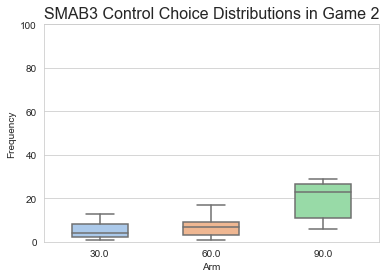

In [263]:
s_g2_counts_box = sns.boxplot( 
                 data=s_g2_counts, 
                 width=0.5,
                 palette="pastel")
s_g2_counts_box.axes.set_title("SMAB3 Control Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="s_g2_counts_box.jpg"

plt.ylim(0, 100)
s_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [51]:
'''Here we get the mean and standard deviation of the number of times participants chose each hole.'''


s_g1_low = np.mean(s_g1_counts.iloc[:,0])
s_g1_med = np.mean(s_g1_counts.iloc[:,1])
s_g1_high = np.mean(s_g1_counts.iloc[:,2])
#s_g1_d_med = np.mean(s_g1_d_counts.iloc[:,1])



In [52]:
s_g1_low

6.066666666666666

In [53]:
s_g1_med

7.266666666666667

In [54]:
s_g1_high

16.666666666666668

In [55]:
s_g1_low_std = np.std(s_g1_counts.iloc[:,0])
s_g1_med_std = np.std(s_g1_counts.iloc[:,1])
s_g1_high_std = np.std(s_g1_counts.iloc[:,2])

In [56]:
s_g1_low_std

4.122566622330749

In [57]:
s_g1_med_std

5.519259209551788

In [58]:
s_g1_high_std

9.148163142887697

In [59]:
'''Here we get the mean and standard deviation of the number of times participants chose each hole.'''


s_g2_low = np.mean(s_g2_counts.iloc[:,0])
s_g2_med = np.mean(s_g2_counts.iloc[:,1])
s_g2_high = np.mean(s_g2_counts.iloc[:,2])
#s_g2_d_med = np.mean(s_g2_d_counts.iloc[:,1])




In [60]:
s_g2_low

5.133333333333334

In [61]:
s_g2_med

6.0

In [62]:
s_g2_high

18.866666666666667

In [63]:
s_g2_low_std = np.std(s_g2_counts.iloc[:,0])
s_g2_med_std = np.std(s_g2_counts.iloc[:,1])
s_g2_high_std = np.std(s_g2_counts.iloc[:,2])

In [64]:
s_g2_low_std

4.544104850120526

In [65]:
s_g2_low_std

4.544104850120526

In [66]:
s_g2_low_std

4.544104850120526

In [67]:
'''Here we place the value counts for each hole for each game into separate numy arrays and compare them statistically.


import researchpy as rp


s_90_1 = np.array(s_g1_counts.iloc[:,2])
s_90_2 = np.array(s_g2_counts.iloc[:,2])

s_60_1 = np.array(s_g1_counts.iloc[:,1])
s_60_2 = np.array(s_g2_counts.iloc[:,1])


s_30_1 = np.array(s_g1_counts.iloc[:,0])
s_30_2 = np.array(s_g2_counts.iloc[:,0])

s_90_p = sp.stats.ttest_rel(s_90_1,s_90_2)
s_60_p = sp.stats.ttest_rel(s_60_1,s_60_2)
s_30_p = sp.stats.ttest_rel(s_30_1,s_30_2)'''

'Here we place the value counts for each hole for each game into separate numy arrays and compare them statistically.\n\n\nimport researchpy as rp\n\n\ns_90_1 = np.array(s_g1_counts.iloc[:,2])\ns_90_2 = np.array(s_g2_counts.iloc[:,2])\n\ns_60_1 = np.array(s_g1_counts.iloc[:,1])\ns_60_2 = np.array(s_g2_counts.iloc[:,1])\n\n\ns_30_1 = np.array(s_g1_counts.iloc[:,0])\ns_30_2 = np.array(s_g2_counts.iloc[:,0])\n\ns_90_p = sp.stats.ttest_rel(s_90_1,s_90_2)\ns_60_p = sp.stats.ttest_rel(s_60_1,s_60_2)\ns_30_p = sp.stats.ttest_rel(s_30_1,s_30_2)'

In [68]:
s01_p1_g1.reset_index(drop=True, inplace=True)

# Reaction Time Analyses

In [69]:
'Here we get the reaction times'
time_s_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_s_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [70]:
time_s_1 = reaction_time(s01_p1_g1, time_s_1)

In [71]:
time_s_1 = reaction_time(s03_p1_g1, time_s_1)
time_s_1 = reaction_time(s05_p1_g1, time_s_1)
time_s_1 = reaction_time(s06_p1_g1, time_s_1)
time_s_1 = reaction_time(s07_p1_g1, time_s_1)
time_s_1 = reaction_time(s08_p1_g1, time_s_1)
time_s_1 = reaction_time(s09_p1_g1, time_s_1)
time_s_1 = reaction_time(s11_p1_g1, time_s_1)
time_s_1 = reaction_time(s12_p1_g1, time_s_1)
time_s_1 = reaction_time(s15_p1_g1, time_s_1)
time_s_1 = reaction_time(s16_p1_g1, time_s_1)
time_s_1 = reaction_time(s17_p1_g1, time_s_1)
time_s_1 = reaction_time(s19_p1_g1, time_s_1)
#time_s_1 = reaction_time(s20_p1_g1, time_s_1)

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [72]:
time_s_2 = reaction_time(s03_p1_g2, time_s_2)
time_s_2 = reaction_time(s05_p1_g2, time_s_2)
time_s_2 = reaction_time(s06_p1_g2, time_s_2)
time_s_2 = reaction_time(s07_p1_g2, time_s_2)
time_s_2 = reaction_time(s08_p1_g2, time_s_2)
time_s_2 = reaction_time(s09_p1_g2, time_s_2)
time_s_2 = reaction_time(s11_p1_g2, time_s_2)
time_s_2 = reaction_time(s12_p1_g2, time_s_2)
time_s_2 = reaction_time(s15_p1_g2, time_s_2)
time_s_2 = reaction_time(s16_p1_g2, time_s_2)
time_s_2 = reaction_time(s17_p1_g2, time_s_2)
time_s_2 = reaction_time(s19_p1_g2, time_s_2)
#time_s_2 = reaction_time(s20_p1_g2, time_s_2)

In [73]:
sp.stats.ttest_rel(time_s_1['post win'], time_s_1['post loss'])

Ttest_relResult(statistic=nan, pvalue=nan)

In [74]:
sp.stats.ttest_rel(time_s_2['post win'], time_s_2['post loss'])

Ttest_relResult(statistic=1.136343499564463, pvalue=0.2799632807606969)

In [75]:
#sp.stats.ttest_rel(time_s_1['post loss'], time_s_2['post loss'])

In [76]:
s01_p1_g1.loc[0,'time']

2.506092072

In [77]:
'''Here we get the average reaction times for each subject in games 1 and 2'''
s01_p1_g1_t = s01_p1_g1['time'].mean()
s01_p1_g2_t = s01_p1_g2['time'].mean()

# SMAB4 Single Player Analysis

In [78]:
'''Here we load the csv files into pandas dataframes by calling organize_trial_by_trial and get the scores in games
1 and 2 by calling call_get_score.'''

df = organize_trial_by_trial_hand_code2('data/c01_gamedata_handcode.csv')
c01 = df
#c02_p1_g1_score,c02_p1_g2_score,c02_score_diff, c02_p1_g1_50,c02_p1_g2_50 = call_get_score(c02, 'c')
c01.head()

df = organize_trial_by_trial('data/c02_gamedata.csv')
c02 = df
c02_p1_g1_score,c02_p1_g2_score,c02_score_diff, c02_p1_g1_50,c02_p1_g2_50 = call_get_score(c02, 'c')
c02.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c03_gamedata.csv')
c03 = df
c03_p1_g1_score,c03_p1_g2_score,c03_score_diff, c03_p1_g1_50,c03_p1_g2_50 = call_get_score(c03, 'c')
c03.head()

df = organize_trial_by_trial_hand_code2('data/c04_gamedata_handcode.csv')
c04 = df
#c04_p1_g1_score,c04_p1_g2_score,c04_score_diff, c04_p1_g1_50,c04_p1_g2_50 = call_get_score(c04, 'c')
c04.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c05_gamedata.csv')
c05 = df
c05_p1_g1_score,c05_p1_g2_score,c05_score_diff, c05_p1_g1_50,c05_p1_g2_50 = call_get_score(c05, 'c')
c05.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c06_gamedata.csv')
c06 = df
c06_p1_g1_score,c06_p1_g2_score,c06_score_diff, c06_p1_g1_50,c06_p1_g2_50 = call_get_score(c06, 'c')
c06.head()


#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c07_gamedata.csv')
c07 = df
c07_p1_g1_score,c07_p1_g2_score,c07_score_diff, c07_p1_g1_50,c07_p1_g2_50 = 78, 86, 8, 34, 42 
#c07.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c09_gamedata.csv')
c09 = df
c09_p1_g1_score,c09_p1_g2_score,c09_score_diff, c09_p1_g1_50,c09_p1_g2_50 = call_get_score(c09, 'c')
c09.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c10_gamedata.csv')
c10 = df
c10_p1_g1_score,c10_p1_g2_score,c10_score_diff, c10_p1_g1_50,c10_p1_g2_50 = call_get_score(c10, 'c')
c10.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c11_gamedata.csv')
c11 = df
c11_p1_g1_score,c11_p1_g2_score,c11_score_diff, c11_p1_g1_50,c11_p1_g2_50 = call_get_score(c11, 'c')
c11.head()

pd.set_option('display.max_columns', None)  

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c12_gamedata2.csv')
c12 = df
c12_p1_g1_score,c12_p1_g2_score,c12_score_diff, c12_p1_g1_50,c12_p1_g2_50 = call_get_score(c12, 'c')
c12.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c13_gamedata2.csv')
c13 = df
c13_p1_g1_score,c13_p1_g2_score,c13_score_diff, c13_p1_g1_50,c13_p1_g2_50 = call_get_score(c13, 'c')
c13.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c14_gamedata2.csv')
c14 = df
c14_p1_g1_score,c14_p1_g2_score,c14_score_diff, c14_p1_g1_50,c14_p1_g2_50 = call_get_score(c14, 'c')
c14.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c15_gamedata.csv')
c15 = df
c15_p1_g1_score,c15_p1_g2_score,c15_score_diff, c15_p1_g1_50,c15_p1_g2_50 = call_get_score(c15, 'c')


#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c16_gamedata2.csv')
c16 = df
c16_p1_g1_score,c16_p1_g2_score,c16_score_diff, c16_p1_g1_50,c16_p1_g2_50 = call_get_score(c16, 'c')
c16.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c17_gamedata2.csv')
c17 = df
c17_p1_g1_score,c17_p1_g2_score,c17_score_diff, c17_p1_g1_50,c17_p1_g2_50 = call_get_score(c17, 'c')
c17#in the s files, p2 is the confederate

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c18_gamedata.csv')
c18 = df
c18_p1_g1_score,c18_p1_g2_score,c18_score_diff, c18_p1_g1_50,c18_p1_g2_50 = call_get_score(c18, 'c')
c18#in the s files, p2 is the confederate



,game number,trial,player,arm,probability,reward,time,P1 score,P2 score
0,1,1,1,3,90,0,5.135425,0,0
1,1,2,2,3,30,0,2.545789,1,0
2,1,3,1,2,60,0,7.996138,1,0
3,1,4,2,3,30,0,3.018310,2,0
4,1,4,1,3,90,0,1.015114,2,0
...,...,...,...,...,...,...,...,...,...
395,2,196,2,3,30,0,3.947417,73,35
396,2,197,1,1,30,0,3.995810,73,35
397,2,198,2,3,30,0,2.867564,73,35
398,2,199,1,3,90,0,3.397195,73,35


In [79]:
c01_p1_counts, c01_p2_counts, c01_p1_probs, c01_p2_probs = handcode_calc_prob(c01)
c04_p1_counts, c04_p2_counts, c04_p1_probs, c04_p2_probs = handcode_calc_prob(c04)

In [80]:
c01_p1_counts

,g1_p1_h1_count,g1_p1_h2_count,g1_p1_h3_count,g2_p1_h1_count,g2_p1_h2_count,g2_p1_h3_count
rewarded,39,20,7,53,20,2
non-rewarded,4,14,14,9,10,10


In [81]:
c04_p1_counts

,g1_p1_h1_count,g1_p1_h2_count,g1_p1_h3_count,g2_p1_h1_count,g2_p1_h2_count,g2_p1_h3_count
rewarded,43,12,1,50,21,1
non-rewarded,5,10,10,7,17,17


In [82]:
c01_p1_probs

,p1_h1,p1_h2,p1_h3
game 1,90.697674,58.823529,33.333333
game 2,85.483871,66.666667,16.666667


In [83]:
c04_p1_probs

,p1_h1,p1_h2,p1_h3
game 1,89.583333,54.545455,9.090909
game 2,87.719298,55.263158,5.555556


In [84]:
#NOT SURE
c01 = fill_in_prob(c01, 90,60,30,90,60,30,30,60,90,30,60,90)
c04 = fill_in_prob(c04, 90,60,30,90,60,30,30,60,90,30,60,90)

In [85]:
c01_p1_g1, c01_p1_g2 = separate_df(c01, 'c')
c04_p1_g1, c04_p1_g2 = separate_df(c04, 'c')

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [86]:
c01_p1_g1_score = c01_p1_g1['reward'].sum()
c01_p1_g2_score = c01_p1_g2['reward'].sum()
c04_p1_g1_score = c04_p1_g1['reward'].sum()
c04_p1_g2_score = c04_p1_g2['reward'].sum()

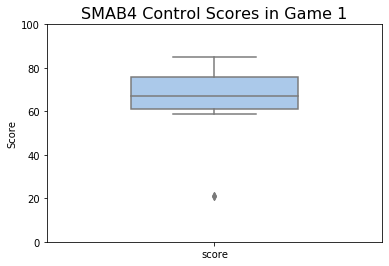

In [90]:
#c_scores1_box = c_scores_1.boxplot()
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))


c_scores1_box = sns.boxplot( 
                 data=c_scores_1, 
                 width=0.5,
                 palette="pastel")
c_scores1_box.axes.set_title("SMAB4 Control Scores in Game 1",
                    fontsize=16)

plot_file_name="c_g1_score_box.jpg"
 
plt.ylim(0, 100)
c_scores1_box.axes.set(ylabel='Score')

# save as jpeg
c_scores1_box.figure.savefig(plot_file_name,
                    format='jpeg')

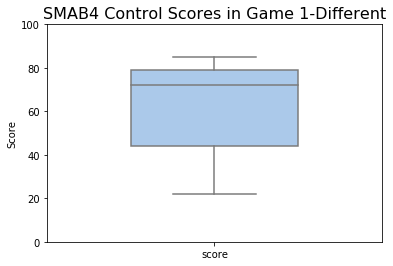

In [91]:
c_scores_2d_box = sns.boxplot( 
                 data=c_scores_2_d, 
                 width=0.5,
                 palette="pastel")
c_scores_2d_box.axes.set_title("SMAB4 Control Scores in Game 1-Different",
                    fontsize=16)

plot_file_name="c_g2d_score_box.jpg"
 
plt.ylim(0, 100)
c_scores_2d_box.axes.set(ylabel='Score')

# save as jpeg
c_scores_2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

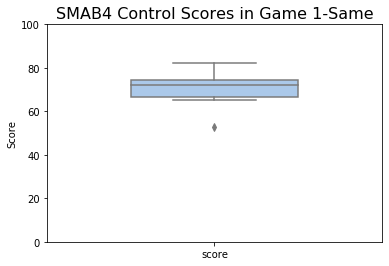

In [92]:
c_scores_2s_box = sns.boxplot( 
                 data=c_scores_2_s, 
                 width=0.5,
                 palette="pastel")
c_scores_2s_box.axes.set_title("SMAB4 Control Scores in Game 1-Same",
                    fontsize=16)

plot_file_name="c_g2s_score_box.jpg"
 
plt.ylim(0, 100)
c_scores_2s_box.axes.set(ylabel='Score')

# save as jpeg
c_scores_2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [93]:
c_scores_2s_mean = c_scores_2_s.mean()

In [94]:
c_scores_2s_std = c_scores_2_s.std()

In [95]:
c_scores_2d_mean = c_scores_2_d.mean()

In [96]:
c_scores_2d_std = c_scores_2_d.std()

In [97]:
c_scores_2s_mean, c_scores_2s_std

(score    69.857143
 dtype: float64, score    9.191093
 dtype: float64)

In [98]:
c_scores_2d_mean, c_scores_2d_std

(score    59.333333
 dtype: float64, score    24.556058
 dtype: float64)

In [99]:
sp.stats.ttest_ind(c_scores_2_s, c_scores_2_d)

Ttest_indResult(statistic=array([1.07016011]), pvalue=array([0.30265113]))

In [102]:
#unnecessary graph
#need to make g1 and g2 bars diff colors
#colors = list(islice(cycle(['red','blue','green', 'yellow']),None,len(c_combo)))
#blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(c_combo)))
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
#c_combo_bar = c_combo.plot(kind='bar',color=colors)

In [256]:
'''Here we separate the dataframes into games 1 and 2.'''

#s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
c02_p1_g1, c02_p1_g2 = separate_df(c02, 'c')
c03_p1_g1, c03_p1_g2 = separate_df(c03, 'c')
c05_p1_g1, c05_p1_g2 = separate_df(c05, 'c')
c06_p1_g1, c06_p1_g2 = separate_df(c06, 'c')
c07_p1_g1, c07_p1_g2 = separate_df(c07, 'c')
c09_p1_g1, c09_p1_g2 = separate_df(c09, 'c')
c10_p1_g1, c10_p1_g2 = separate_df(c10, 'c')
c11_p1_g1, c11_p1_g2 = separate_df(c11, 'c')
c12_p1_g1, c12_p1_g2 = separate_df(c12, 'c')
c13_p1_g1, c13_p1_g2 = separate_df(c13, 'c')
c14_p1_g1, c14_p1_g2 = separate_df(c14, 'c')
c15_p1_g1, c15_p1_g2 = separate_df(c15, 'c')
c16_p1_g1, c16_p1_g2 = separate_df(c16, 'c')
c17_p1_g1, c17_p1_g2 = separate_df(c17, 'c')
c18_p1_g1, c18_p1_g2 = separate_df(c18, 'c')

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [117]:
#call fix_reward on all of the files imported with '300' to fix the reward column
c12_p1_g1 = fix_reward(c12_p1_g1)
c12_p1_g2 = fix_reward(c12_p1_g2)
c13_p1_g1 = fix_reward(c13_p1_g1)
c13_p1_g2 = fix_reward(c13_p1_g2)
c14_p1_g1 = fix_reward(c14_p1_g1)
c14_p1_g2 = fix_reward(c14_p1_g2)
c15_p1_g1 = fix_reward(c15_p1_g1)
c15_p1_g2 = fix_reward(c15_p1_g2)
c16_p1_g1 = fix_reward(c16_p1_g1)
c16_p1_g2 = fix_reward(c16_p1_g2)
c17_p1_g1 = fix_reward(c17_p1_g1)
c17_p1_g2 = fix_reward(c17_p1_g2)
c18_p1_g1 = fix_reward(c18_p1_g1)
c18_p1_g2 = fix_reward(c18_p1_g2)


In [119]:
'''Here we count the number of times each hole was chosen in each game and place it in an array.'''

c01_p1_g1_count = c01_p1_g1['probability'].value_counts(sort=False)
c01_p1_g2_count = c01_p1_g2['probability'].value_counts(sort=False)
c02_p1_g1_count = c02_p1_g1['probability'].value_counts(sort=False)
c02_p1_g2_count = c02_p1_g2['probability'].value_counts(sort=False)
c03_p1_g1_count = c03_p1_g1['probability'].value_counts(sort=False)
c03_p1_g2_count = c03_p1_g2['probability'].value_counts(sort=False)
c04_p1_g1_count = c04_p1_g1['probability'].value_counts(sort=False)
c04_p1_g2_count = c04_p1_g2['probability'].value_counts(sort=False)
c05_p1_g1_count = c05_p1_g1['probability'].value_counts(sort=False)
c05_p1_g2_count = c05_p1_g2['probability'].value_counts(sort=False)
c06_p1_g1_count = c06_p1_g1['probability'].value_counts(sort=False)
c06_p1_g2_count = c06_p1_g2['probability'].value_counts(sort=False)
c07_p1_g1_count = c07_p1_g1['probability'].value_counts(sort=False)
c07_p1_g2_count = c07_p1_g2['probability'].value_counts(sort=False)
c09_p1_g1_count = c09_p1_g1['probability'].value_counts(sort=False)
c09_p1_g2_count = c09_p1_g2['probability'].value_counts(sort=False)
c10_p1_g1_count = c10_p1_g1['probability'].value_counts(sort=False)
c10_p1_g2_count = c10_p1_g2['probability'].value_counts(sort=False)
c11_p1_g1_count = c11_p1_g1['probability'].value_counts(sort=False)
c11_p1_g2_count = c11_p1_g2['probability'].value_counts(sort=False)
c12_p1_g1_count = c12_p1_g1['probability'].value_counts(sort=False)
c12_p1_g2_count = c12_p1_g2['probability'].value_counts(sort=False)
c13_p1_g1_count = c13_p1_g1['probability'].value_counts(sort=False)
c13_p1_g2_count = c13_p1_g2['probability'].value_counts(sort=False)
c14_p1_g1_count = c14_p1_g1['probability'].value_counts(sort=False)
c14_p1_g2_count = c14_p1_g2['probability'].value_counts(sort=False)
c15_p1_g1_count = c15_p1_g1['probability'].value_counts(sort=False)
c15_p1_g2_count = c15_p1_g2['probability'].value_counts(sort=False)
c16_p1_g1_count = c16_p1_g1['probability'].value_counts(sort=False)
c16_p1_g2_count = c16_p1_g2['probability'].value_counts(sort=False)
c17_p1_g1_count = c17_p1_g1['probability'].value_counts(sort=False)
c17_p1_g2_count = c17_p1_g2['probability'].value_counts(sort=False)
c18_p1_g1_count = c18_p1_g1['probability'].value_counts(sort=False)
c18_p1_g2_count = c18_p1_g2['probability'].value_counts(sort=False)

# COMBINED CHOICE SINGLE PLAYER

In [293]:

'''Here we place the number of times each hole was chosen by each subject in game 1 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''

#GAME 1

c_g1_counts = pd.DataFrame([s01_p1_g1_count, s03_p1_g1_count, 
                            s05_p1_g1_count, s06_p1_g1_count, s07_p1_g1_count, s08_p1_g1_count, s09_p1_g1_count, s11_p1_g1_count, s12_p1_g1_count, s14_p1_g1_count, s15_p1_g1_count, s16_p1_g1_count,
                    s17_p1_g1_count, s19_p1_g1_count, s20_p1_g1_count, c01_p1_g1_count, c02_p1_g1_count, c03_p1_g1_count, c04_p1_g1_count,
                            c05_p1_g1_count, c06_p1_g1_count, c07_p1_g1_count, c09_p1_g1_count, c10_p1_g1_count, c11_p1_g1_count, c12_p1_g1_count, c13_p1_g1_count, c14_p1_g1_count, c15_p1_g1_count,
                            c16_p1_g1_count, c17_p1_g1_count, c18_p1_g1_count],
         index=['s01_p1_g1_count', 's03_p1_g1_count', 's05_p1_g1_count', 's06_p1_g1_count',
                                 's07_p1_g1_count', 's08_p1_g1_count', 's09_p1_g1_count', 's11_p1_g1_count', 's12_p1_g1_count', 's14_p1_g1_count', 's15_p1_g1_count',
                                 's16_p1_g1_count', 's17_p1_g1_count', 's19_p1_g1_count', 's20_p1_g1_count','c01_p1_g1_count', 'c02_p1_g1_count', 'c03_p1_g1_count', 'c04_p1_g1_count', 'c05_p1_g1_count', 'c06_p1_g1_count', 
                'c07_p1_g1_count','c09_p1_g1_count', 'c10_p1_g1_count', 'c11_p1_g1_count', 'c12_p1_g1_count', 'c13_p1_g1_count', 'c14_p1_g1_count', 
                'c15_p1_g1_count', 'c16_p1_g1_count', 'c17_p1_g1_count', 'c18_p1_g1_count'])


#How to prevent NaN: df = df.fillna(0)
c_g1_counts = c_g1_counts.fillna(0)

#print
c_g1_counts


c_g1_counts.sum(axis=1)

s01_p1_g1_count    30.0
s03_p1_g1_count    30.0
s05_p1_g1_count    30.0
s06_p1_g1_count    30.0
s07_p1_g1_count    30.0
s08_p1_g1_count    30.0
s09_p1_g1_count    30.0
s11_p1_g1_count    30.0
s12_p1_g1_count    30.0
s14_p1_g1_count    30.0
s15_p1_g1_count    30.0
s16_p1_g1_count    30.0
s17_p1_g1_count    30.0
s19_p1_g1_count    30.0
s20_p1_g1_count    30.0
c01_p1_g1_count    30.0
c02_p1_g1_count    30.0
c03_p1_g1_count    30.0
c04_p1_g1_count    30.0
c05_p1_g1_count    30.0
c06_p1_g1_count    30.0
c07_p1_g1_count    30.0
c09_p1_g1_count    30.0
c10_p1_g1_count    30.0
c11_p1_g1_count    30.0
c12_p1_g1_count    30.0
c13_p1_g1_count    30.0
c14_p1_g1_count    30.0
c15_p1_g1_count    30.0
c16_p1_g1_count    30.0
c17_p1_g1_count    30.0
c18_p1_g1_count    30.0
dtype: float64

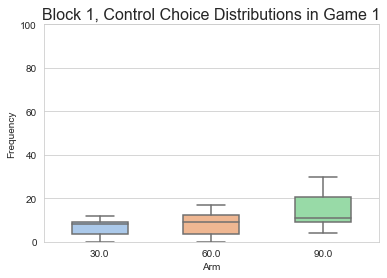

In [294]:
c_g1_counts_box = sns.boxplot( 
                 data=c_g1_counts, 
                 width=0.5,
                 palette="pastel")
c_g1_counts_box.axes.set_title("Block 1, Control Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="c_g1_counts_box.jpg"
 
plt.ylim(0, 100)
c_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [308]:
'''Here we place the number of times each hole was chosen by each subject in game 2 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''

#GAME 2
c_g2_counts = pd.DataFrame([s01_p1_g2_count, s03_p1_g2_count, 
                            s05_p1_g2_count, s06_p1_g2_count, s07_p1_g2_count, s08_p1_g2_count, s09_p1_g2_count, s11_p1_g2_count, s12_p1_g2_count, s14_p1_g2_count, s15_p1_g2_count, s16_p1_g2_count,
                    s17_p1_g2_count, s19_p1_g2_count, s20_p1_g2_count, c02_p1_g2_count, c03_p1_g2_count,
                            c05_p1_g2_count, c06_p1_g2_count, c09_p1_g2_count, c10_p1_g2_count, c11_p1_g2_count, c01_p1_g2_count, c04_p1_g2_count, c12_p1_g2_count, c13_p1_g2_count, c14_p1_g2_count, c15_p1_g2_count, c16_p1_g2_count, c17_p1_g2_count, c18_p1_g2_count],
         index=['s01_p1_g2_count', 's03_p1_g2_count', 's05_p1_g2_count', 's06_p1_g2_count',
                                 's07_p1_g2_count', 's08_p1_g2_count', 's09_p1_g2_count', 's11_p1_g2_count', 's12_p1_g2_count', 's14_p1_g2_count', 's15_p1_g2_count',
                                 's16_p1_g2_count', 's17_p1_g2_count', 's19_p1_g2_count', 's20_p1_g2_count','c02_p1_g2_count', 'c03_p1_g2_count', 'c05_p1_g2_count', 'c06_p1_g2_count', 
                'c09_p1_g2_count', 'c10_p1_g2_count', 'c11_p1_g2_count', 'c01_p1_g2_count', 'c04_p1_g2_count','c12_p1_g2_count', 'c13_p1_g2_count', 
                'c14_p1_g2_count', 'c15_p1_g2_count',
                'c16_p1_g2_count', 'c17_p1_g2_count', 'c18_p1_g2_count'])








#How to prevent NaN: df = df.fillna(0)
c_g2_counts = c_g2_counts.fillna(0)

#print
c_g2_counts


c_g2_counts.sum(axis=1)


s01_p1_g2_count    30.0
s03_p1_g2_count    30.0
s05_p1_g2_count    30.0
s06_p1_g2_count    30.0
s07_p1_g2_count    30.0
s08_p1_g2_count    30.0
s09_p1_g2_count    30.0
s11_p1_g2_count    30.0
s12_p1_g2_count    30.0
s14_p1_g2_count    30.0
s15_p1_g2_count    30.0
s16_p1_g2_count    30.0
s17_p1_g2_count    30.0
s19_p1_g2_count    30.0
s20_p1_g2_count    30.0
c02_p1_g2_count    30.0
c03_p1_g2_count    30.0
c05_p1_g2_count    30.0
c06_p1_g2_count    30.0
c09_p1_g2_count    30.0
c10_p1_g2_count    30.0
c11_p1_g2_count    30.0
c01_p1_g2_count    30.0
c04_p1_g2_count    30.0
c12_p1_g2_count    30.0
c13_p1_g2_count    30.0
c14_p1_g2_count    30.0
c15_p1_g2_count    30.0
c16_p1_g2_count    30.0
c17_p1_g2_count    30.0
c18_p1_g2_count    30.0
dtype: float64

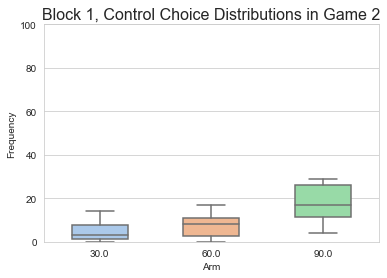

In [310]:
c_g2_counts_box = sns.boxplot( 
                 data=c_g2_counts, 
                 width=0.5,
                 palette="pastel")
c_g2_counts_box.axes.set_title("Block 1, Control Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="c_g2_counts_box.jpg"
 
plt.ylim(0, 100)
c_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [301]:
c_g1_low = np.mean(c_g1_counts.iloc[:,0])
c_g1_med = np.mean(c_g1_counts.iloc[:,1])
c_g1_high = np.mean(c_g1_counts.iloc[:,2])

c_g1_low_std = np.std(c_g1_counts.iloc[:,0])
c_g1_med_std = np.std(c_g1_counts.iloc[:,1])
c_g1_high_std = np.std(c_g1_counts.iloc[:,2])

In [302]:
(c_g1_low, c_g1_med, c_g1_high)

(6.71875, 8.375, 14.90625)

In [303]:
(c_g1_low_std, c_g1_med_std, c_g1_high_std)

(3.5287601841865084, 5.048205126577168, 7.883366091810021)

In [304]:
c_g2_low = np.mean(c_g2_counts.iloc[:,0])
c_g2_med = np.mean(c_g2_counts.iloc[:,1])
c_g2_high = np.mean(c_g2_counts.iloc[:,2])

c_g2_low_std = np.std(c_g2_counts.iloc[:,0])
c_g2_med_std = np.std(c_g2_counts.iloc[:,1])
c_g2_high_std = np.std(c_g2_counts.iloc[:,2])

In [305]:
(c_g2_low, c_g2_med, c_g2_high)

(4.806451612903226, 7.096774193548387, 18.096774193548388)

In [306]:
(c_g2_low_std, c_g2_med_std, c_g2_high_std)

(4.395153891677703, 4.788122662007606, 7.830275563517822)

In [307]:
sp.stats.ttest_ind(c_g1_counts, c_g2_counts)

Ttest_indResult(statistic=array([ 1.87668596,  1.01403036, -1.58551235]), pvalue=array([0.06534641, 0.31457358, 0.11802088]))

In [134]:
#sp.stats.ttest_ind(c_g1_scores, c_g2_s_scores)

# Reaction Time Analyses

In [135]:
'Here we get the reaction times'
'NEED to fix rewards for SMAB4'
time_c_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_c_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [136]:
time_c_1 = reaction_time(c02_p1_g1, time_c_1)
time_c_1 = reaction_time(c03_p1_g1, time_c_1)
time_c_1 = reaction_time(c05_p1_g1, time_c_1)
time_c_1 = reaction_time(c06_p1_g1, time_c_1)
time_c_1 = reaction_time(c09_p1_g1, time_c_1)
time_c_1 = reaction_time(c10_p1_g1, time_c_1)
time_c_1 = reaction_time(c11_p1_g1, time_c_1)
time_c_1 = reaction_time(c12_p1_g1, time_c_1)
time_c_1 = reaction_time(c13_p1_g1, time_c_1)
time_c_1 = reaction_time(c14_p1_g1, time_c_1)
time_c_1 = reaction_time(c15_p1_g1, time_c_1)
time_c_1 = reaction_time(c16_p1_g1, time_c_1)
time_c_1 = reaction_time(c17_p1_g1, time_c_1)
time_c_1 = reaction_time(c18_p1_g1, time_c_1)

In [137]:
time_c_1

,session,post win,post loss
0,c02_p1_g1,4.257012,6.589807
1,c03_p1_g1,3.457620,3.434314
2,c05_p1_g1,3.824453,3.812090
3,c06_p1_g1,3.125762,2.753691
4,c09_p1_g1,3.315176,3.288630
5,c10_p1_g1,3.122579,3.439771
6,c11_p1_g1,3.853327,4.203817
7,c12_p1_g1,3.776948,4.019729
8,c13_p1_g1,3.630673,3.798113
9,c14_p1_g1,3.202178,3.198625


In [138]:
time_c_2 = reaction_time(c02_p1_g2, time_c_2)
time_c_2 = reaction_time(c03_p1_g2, time_c_2)
time_c_2 = reaction_time(c05_p1_g2, time_c_2)
time_c_2 = reaction_time(c06_p1_g2, time_c_2)
time_c_2 = reaction_time(c09_p1_g2, time_c_2)
time_c_2 = reaction_time(c10_p1_g2, time_c_2)
time_c_2 = reaction_time(c11_p1_g2, time_c_2)
time_c_2 = reaction_time(c12_p1_g2, time_c_2)
time_c_2 = reaction_time(c13_p1_g2, time_c_2)
time_c_2 = reaction_time(c14_p1_g2, time_c_2)
time_c_2 = reaction_time(c15_p1_g2, time_c_2)
time_c_2 = reaction_time(c16_p1_g2, time_c_2)
time_c_2 = reaction_time(c17_p1_g2, time_c_2)
time_c_2 = reaction_time(c18_p1_g2, time_c_2)

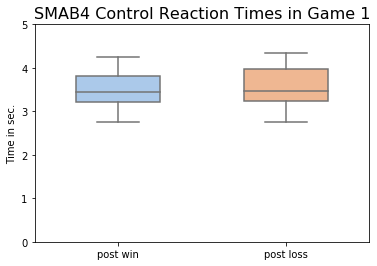

In [139]:
times_c_g1_box = sns.boxplot( 
                 data=time_c_1, 
                 width=0.5,
                 palette="pastel")
times_c_g1_box.axes.set_title("SMAB4 Control Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_c_g1_box.jpg"
 
plt.ylim(0, 5)
times_c_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_c_g1_box.figure.savefig(plot_file_name,format='jpeg')

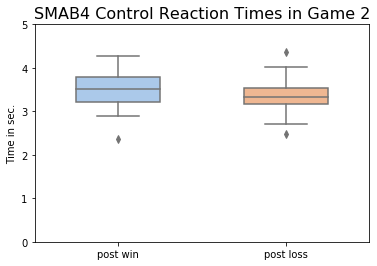

In [140]:
times_c_g2_box = sns.boxplot( 
                 data=time_c_2, 
                 width=0.5,
                 palette="pastel")
times_c_g2_box.axes.set_title("SMAB4 Control Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_c_g2_box.jpg"
 
plt.ylim(0, 5)
times_c_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_c_g2_box.figure.savefig(plot_file_name,format='jpeg')

In [141]:
np.mean(time_c_1)

post win     3.517299
post loss    3.741726
dtype: float64

In [142]:
np.mean(time_c_2)

post win     3.484933
post loss    3.354428
dtype: float64

In [143]:
np.std(time_c_1)

post win     0.420901
post loss    0.913085
dtype: float64

In [144]:
np.std(time_c_2)

post win     0.482295
post loss    0.467945
dtype: float64

In [145]:
sp.stats.ttest_rel(time_c_1['post win'],time_c_1['post loss'])

Ttest_relResult(statistic=-1.3273281251375004, pvalue=0.20723976886930365)

In [146]:
sp.stats.ttest_rel(time_c_2['post win'],time_c_2['post loss'])

Ttest_relResult(statistic=2.565666240860327, pvalue=0.023485772048290256)

In [147]:
#not working
#sp.stats.ttest_rel(time_c_1['post win'],time_c_2['post win'])

In [148]:
#not working
#sp.stats.ttest_rel(time_c_1['post loss'],time_c_2['post loss'])

In [149]:
s01_p1_g2_count

90    13
60     4
30    13
Name: probability, dtype: int64

# SMAB3 Joint Analysis

In [311]:
'''Here we load the csv files into Pandas dataframes by calling organize_trial_by_trial and get the score of each subject 
in each game by calling call_get_score.'''


df = organize_trial_by_trial('data/j01_gamedata.csv')
j01 = df
j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j01_p1_diff,j01_p2_diff,j01_p1_g1_50,j01_p1_g2_50,j01_p2_g1_50,j01_p2_g2_50= call_get_score(j01, 'j')
j01.head()

df = organize_trial_by_trial('data/j02_gamedata.csv')
j02 = df
j02_p1_g1_score,j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j02_p1_diff,j02_p2_diff,j02_p1_g1_50,j02_p1_g2_50,j02_p2_g1_50,j02_p2_g2_50 = call_get_score(j02, 'j')
j02.head()


df = organize_trial_by_trial('data/j03_gamedata.csv')
j03 = df
j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j03_p1_diff,j03_p2_diff,j03_p1_g1_50,j03_p1_g2_50,j03_p2_g1_50,j03_p2_g2_50 = call_get_score(j03, 'j')
j03.head()


df = organize_trial_by_trial('data/j04_gamedata.csv')
j04 = df
j04_p1_g1_score,j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j04_p1_diff,j04_p2_diff,j04_p1_g1_50,j04_p1_g2_50,j04_p2_g1_50,j04_p2_g2_50 = call_get_score(j04, 'j')
j04.head()


df = organize_trial_by_trial('data/j05_gamedata.csv')
j05 = df
j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j05_p1_diff,j05_p2_diff,j05_p1_g1_50,j05_p1_g2_50,j05_p2_g1_50,j05_p2_g2_50 = call_get_score(j05, 'j')
j05.head()


df = organize_trial_by_trial('data/j06_gamedata.csv')
j06 = df
j06_p1_g1_score,j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score,j06_p1_diff,j06_p2_diff,j06_p1_g1_50,j06_p1_g2_50,j06_p2_g1_50,j06_p2_g2_50 = call_get_score(j06, 'j')
j06.head()


df = organize_trial_by_trial('data/j07_gamedata.csv')
j07 = df
j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,j07_p2_g2_score,j07_p1_diff,j07_p2_diff,j07_p1_g1_50,j07_p1_g2_50,j07_p2_g1_50,j07_p2_g2_50 = call_get_score(j07, 'j')
j07.head()


df = organize_trial_by_trial('data/j08_gamedata.csv')
j08 = df
j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score,j08_p1_diff,j08_p2_diff,j08_p1_g1_50,j08_p1_g2_50,j08_p2_g1_50,j08_p2_g2_50 = call_get_score(j08, 'j')
j08.head()


df = organize_trial_by_trial_300('data/j10_gamedata2.csv')
j10 = df
j10_p1_g1_score,j10_p1_g2_score,j10_p2_g1_score,j10_p2_g2_score,j10_p1_diff,j10_p2_diff,j10_p1_g1_50,j10_p1_g2_50,j10_p2_g1_50,j10_p2_g2_50 = call_get_score(j10, 'j')
j10.head()


df = organize_trial_by_trial_300('data/j11_gamedata2.csv')
j11 = df
j11_p1_g1_score,j11_p1_g2_score,j11_p2_g1_score,j11_p2_g2_score,j11_p1_diff,j11_p2_diff,j11_p1_g1_50,j11_p1_g2_50,j11_p2_g1_50,j11_p2_g2_50 = call_get_score(j11, 'j')
j11.head()

#NEED to add j12 to other analyses
''''df = organize_trial_by_trial_300('data/j12_gamedata_old.csv')
j12 = df
j12_p1_g1_score,j12_p1_g2_score,j12_p2_g1_score,j12_p2_g2_score,j12_p1_diff,j12_p2_diff,j12_p1_g1_50,j12_p1_g2_50,j12_p2_g1_50,j12_p2_g2_50 = call_get_score(j12, 'j')
j12.head()'''

"'df = organize_trial_by_trial_300('data/j12_gamedata_old.csv')\nj12 = df\nj12_p1_g1_score,j12_p1_g2_score,j12_p2_g1_score,j12_p2_g2_score,j12_p1_diff,j12_p2_diff,j12_p1_g1_50,j12_p1_g2_50,j12_p2_g1_50,j12_p2_g2_50 = call_get_score(j12, 'j')\nj12.head()"

In [312]:
'''Here we separate the dataframes by suject and game by calling separate_df. We also create arrays with the number of
times that each subject chose each hole by calling value_counts.'''

j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')
j10_p1_g1, j10_p1_g2, j10_p2_g1, j10_p2_g2 = separate_df(j10, 'j')
j11_p1_g1, j11_p1_g2, j11_p2_g1, j11_p2_g2 = separate_df(j11, 'j')



j01_p1_g1_count = j01_p1_g1['probability'].value_counts(sort=False)
j01_p1_g2_count = j01_p1_g2['probability'].value_counts(sort=False)
j01_p2_g1_count = j01_p2_g1['probability'].value_counts(sort=False)
j01_p2_g2_count = j01_p2_g2['probability'].value_counts(sort=False)
j02_p1_g1_count = j02_p1_g1['probability'].value_counts(sort=False)
j02_p1_g2_count = j02_p1_g2['probability'].value_counts(sort=False)
j02_p2_g1_count = j02_p2_g1['probability'].value_counts(sort=False)
j02_p2_g2_count = j02_p2_g2['probability'].value_counts(sort=False)
j03_p1_g1_count = j03_p1_g1['probability'].value_counts(sort=False)
j03_p1_g2_count = j03_p1_g2['probability'].value_counts(sort=False)
j03_p2_g1_count = j03_p2_g1['probability'].value_counts(sort=False)
j03_p2_g2_count = j03_p2_g2['probability'].value_counts(sort=False)
j04_p1_g1_count = j04_p1_g1['probability'].value_counts(sort=False)
j04_p1_g2_count = j04_p1_g2['probability'].value_counts(sort=False)
j04_p2_g1_count = j04_p2_g1['probability'].value_counts(sort=False)
j04_p2_g2_count = j04_p2_g2['probability'].value_counts(sort=False)
j05_p1_g1_count = j05_p1_g1['probability'].value_counts(sort=False)
j05_p1_g2_count = j05_p1_g2['probability'].value_counts(sort=False)
j05_p2_g1_count = j05_p2_g1['probability'].value_counts(sort=False)
j05_p2_g2_count = j05_p2_g2['probability'].value_counts(sort=False)
j06_p1_g1_count = j06_p1_g1['probability'].value_counts(sort=False)
j06_p1_g2_count = j06_p1_g2['probability'].value_counts(sort=False)
j06_p2_g1_count = j06_p2_g1['probability'].value_counts(sort=False)
j06_p2_g2_count = j06_p2_g2['probability'].value_counts(sort=False)
j07_p1_g1_count = j07_p1_g1['probability'].value_counts(sort=False)
j07_p1_g2_count = j07_p1_g2['probability'].value_counts(sort=False)
j07_p2_g1_count = j07_p2_g1['probability'].value_counts(sort=False)
j07_p2_g2_count = j07_p2_g2['probability'].value_counts(sort=False)
j08_p1_g1_count = j08_p1_g1['probability'].value_counts(sort=False)
j08_p1_g2_count = j08_p1_g2['probability'].value_counts(sort=False)
j08_p2_g1_count = j08_p2_g1['probability'].value_counts(sort=False)
j08_p2_g2_count = j08_p2_g2['probability'].value_counts(sort=False)
j10_p1_g1_count = j10_p1_g1['probability'].value_counts(sort=False)
j10_p1_g2_count = j10_p1_g2['probability'].value_counts(sort=False)
j10_p2_g1_count = j10_p2_g1['probability'].value_counts(sort=False)
j10_p2_g2_count = j10_p2_g2['probability'].value_counts(sort=False)
j11_p1_g1_count = j11_p1_g1['probability'].value_counts(sort=False)
j11_p1_g2_count = j11_p1_g2['probability'].value_counts(sort=False)
j11_p2_g1_count = j11_p2_g1['probability'].value_counts(sort=False)
j11_p2_g2_count = j11_p2_g2['probability'].value_counts(sort=False)

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [313]:
'''Here we mech the hole-probability mappings in each game for each player'''
#INDEXER ERROR
'''j01_p1_g1_map = hole_prob_map(j01_p1_g1)
j01_p1_g2_map = hole_prob_map(j01_p1_g2)
j01_p2_g1_map = hole_prob_map(j01_p2_g1)
j01_p2_g2_map = hole_prob_map(j01_p2_g2)

j02_p1_g1_map = hole_prob_map(j02_p1_g1)
j02_p1_g2_map = hole_prob_map(j02_p1_g2)
j02_p2_g1_map = hole_prob_map(j02_p2_g1)
j02_p2_g2_map = hole_prob_map(j02_p2_g2)

j03_p1_g1_map = hole_prob_map(j03_p1_g1)
j03_p1_g2_map = hole_prob_map(j03_p1_g2)
j03_p2_g1_map = hole_prob_map(j03_p2_g1)
j03_p2_g2_map = hole_prob_map(j03_p2_g2)

j04_p1_g1_map = hole_prob_map(j04_p1_g1)
j04_p1_g2_map = hole_prob_map(j04_p1_g2)
j04_p2_g1_map = hole_prob_map(j04_p2_g1)
j04_p2_g2_map = hole_prob_map(j04_p2_g2)

j05_p1_g1_map = hole_prob_map(j05_p1_g1)
j05_p1_g2_map = hole_prob_map(j05_p1_g2)
j05_p2_g1_map = hole_prob_map(j05_p2_g1)
j05_p2_g2_map = hole_prob_map(j05_p2_g2)

j06_p1_g1_map = hole_prob_map(j06_p1_g1)
j06_p1_g2_map = hole_prob_map(j06_p1_g2)
j06_p2_g1_map = hole_prob_map(j06_p2_g1)
j06_p2_g2_map = hole_prob_map(j06_p2_g2)

j07_p1_g1_map = hole_prob_map(j07_p1_g1)
j07_p1_g2_map = hole_prob_map(j07_p1_g2)
j07_p2_g1_map = hole_prob_map(j07_p2_g1)
j07_p2_g2_map = hole_prob_map(j07_p2_g2)

j08_p1_g1_map = hole_prob_map(j08_p1_g1)
j08_p1_g2_map = hole_prob_map(j08_p1_g2)
j08_p2_g1_map = hole_prob_map(j08_p2_g1)
j08_p2_g2_map = hole_prob_map(j08_p2_g2)

j10_p1_g1_map = hole_prob_map(j10_p1_g1)
j10_p1_g2_map = hole_prob_map(j10_p1_g2)
j10_p2_g1_map = hole_prob_map(j10_p2_g1)
j10_p2_g2_map = hole_prob_map(j10_p2_g2)

'''
#j11_p1_g1_map = hole_prob_map(j11_p1_g1)
#j11_p1_g2_map = hole_prob_map(j11_p1_g2)
#j11_p2_g1_map = hole_prob_map(j11_p2_g1)
#j11_p2_g2_map = hole_prob_map(j11_p2_g2)

'j01_p1_g1_map = hole_prob_map(j01_p1_g1)\nj01_p1_g2_map = hole_prob_map(j01_p1_g2)\nj01_p2_g1_map = hole_prob_map(j01_p2_g1)\nj01_p2_g2_map = hole_prob_map(j01_p2_g2)\n\nj02_p1_g1_map = hole_prob_map(j02_p1_g1)\nj02_p1_g2_map = hole_prob_map(j02_p1_g2)\nj02_p2_g1_map = hole_prob_map(j02_p2_g1)\nj02_p2_g2_map = hole_prob_map(j02_p2_g2)\n\nj03_p1_g1_map = hole_prob_map(j03_p1_g1)\nj03_p1_g2_map = hole_prob_map(j03_p1_g2)\nj03_p2_g1_map = hole_prob_map(j03_p2_g1)\nj03_p2_g2_map = hole_prob_map(j03_p2_g2)\n\nj04_p1_g1_map = hole_prob_map(j04_p1_g1)\nj04_p1_g2_map = hole_prob_map(j04_p1_g2)\nj04_p2_g1_map = hole_prob_map(j04_p2_g1)\nj04_p2_g2_map = hole_prob_map(j04_p2_g2)\n\nj05_p1_g1_map = hole_prob_map(j05_p1_g1)\nj05_p1_g2_map = hole_prob_map(j05_p1_g2)\nj05_p2_g1_map = hole_prob_map(j05_p2_g1)\nj05_p2_g2_map = hole_prob_map(j05_p2_g2)\n\nj06_p1_g1_map = hole_prob_map(j06_p1_g1)\nj06_p1_g2_map = hole_prob_map(j06_p1_g2)\nj06_p2_g1_map = hole_prob_map(j06_p2_g1)\nj06_p2_g2_map = hole_pr

In [314]:
'''Here we create dataframes with all of the scores of each subject in games 1 and 2. 50 refers to the score half-way
through the games'''


# # Combined Joint scores G1

j_scores_1 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_1':
     [j01_p1_g1_score, j01_p2_g1_score, j02_p1_g1_score, j02_p2_g1_score, j03_p1_g1_score, j03_p2_g1_score,
      j04_p1_g1_score, j04_p2_g1_score, j05_p1_g1_score, j05_p2_g1_score, j06_p1_g1_score, j06_p2_g1_score,
      j07_p1_g1_score, j07_p2_g1_score, j08_p1_g1_score, j08_p2_g1_score, j10_p1_g1_score, j10_p2_g1_score, j11_p1_g1_score, j11_p2_g1_score]})
j_scores_1.set_index('participant', inplace=True, drop=True)
j_scores_1


# # Combined Joint scores G2

# In[ ]:


j_scores_2_d = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2'], 'score_2':
     [j01_p1_g2_score, j01_p2_g2_score, j02_p1_g2_score, j02_p2_g2_score, j03_p1_g2_score, j03_p2_g2_score,
      j04_p1_g2_score, j04_p2_g2_score, j05_p1_g2_score, j05_p2_g2_score, j06_p1_g2_score, j06_p2_g2_score,
      j07_p1_g2_score, j07_p2_g2_score, j08_p1_g2_score, j08_p2_g2_score]})
j_scores_2_d.set_index('participant', inplace=True, drop=True)

j_scores_2_s = pd.DataFrame({'participant':['j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_2':
     [j10_p1_g2_score, j10_p2_g2_score, j11_p1_g2_score, j11_p2_g2_score]})
j_scores_2_s.set_index('participant', inplace=True, drop=True)

j_scores_1_50 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_1_50':
     [j01_p1_g1_50, j01_p2_g1_50, j02_p1_g1_50, j02_p2_g1_50, j03_p1_g1_50, j03_p2_g1_50,
      j04_p1_g1_50, j04_p2_g1_50, j05_p1_g1_50, j05_p2_g1_50, j06_p1_g1_50, j06_p2_g1_50,
      j07_p1_g1_50, j07_p2_g1_50, j08_p1_g1_50, j08_p2_g1_50, j10_p1_g1_50, j10_p2_g1_50, j11_p1_g1_50, j11_p2_g1_50]})
j_scores_1_50.set_index('participant', inplace=True, drop=True)




j_scores_2_50 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_2_50':
     [j01_p1_g2_50, j01_p2_g2_50, j02_p1_g2_50, j02_p2_g2_50, j03_p1_g2_50, j03_p2_g2_50,
      j04_p1_g2_50, j04_p2_g2_50, j05_p1_g2_50, j05_p2_g2_50, j06_p1_g2_50, j06_p2_g2_50,
      j07_p1_g2_50, j07_p2_g2_50, j08_p1_g2_50, j08_p2_g2_50, j10_p1_g2_50, j10_p2_g2_50, j11_p1_g2_50, j11_p2_g2_50]})
j_scores_2_50.set_index('participant', inplace=True, drop=True)



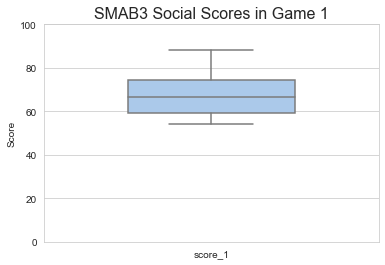

In [315]:
j_scores_1_box = sns.boxplot( 
                 data=j_scores_1, 
                 width=0.5,
                 palette="pastel")
j_scores_1_box.axes.set_title("SMAB3 Social Scores in Game 1",
                    fontsize=16)

plot_file_name="j_score_1_box.jpg"
 
plt.ylim(0, 100)
j_scores_1_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_1_box.figure.savefig(plot_file_name,
                    format='jpeg')

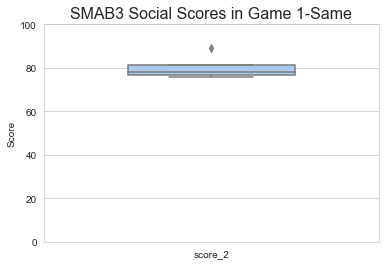

In [316]:
j_scores_2s_box = sns.boxplot( 
                 data=j_scores_2_s, 
                 width=0.5,
                 palette="pastel")
j_scores_2s_box.axes.set_title("SMAB3 Social Scores in Game 1-Same",
                    fontsize=16)

plot_file_name="j_score_2s_box.jpg"
 
plt.ylim(0, 100)
j_scores_2s_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

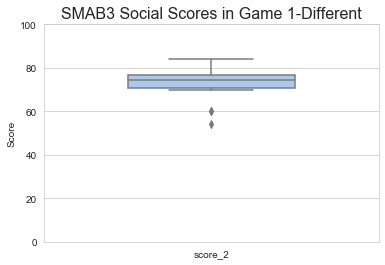

In [317]:
j_scores_2d_box = sns.boxplot( 
                 data=j_scores_2_d, 
                 width=0.5,
                 palette="pastel")
j_scores_2d_box.axes.set_title("SMAB3 Social Scores in Game 1-Different",
                    fontsize=16)

plot_file_name="j_score_2d_box.jpg"
 
plt.ylim(0, 100)
j_scores_2d_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [318]:
j_scores_2s_mean = j_scores_2_s.mean()

In [319]:
j_scores_2d_mean = j_scores_2_d.mean()

In [320]:
j_scores_2s_std = j_scores_2_s.std()

In [321]:
j_scores_2d_std = j_scores_2_d.std()

In [322]:
j_scores_2s_mean, j_scores_2s_std

(score_2    80.25
 dtype: float64, score_2    5.965177
 dtype: float64)

In [162]:
j_scores_2d_mean, j_scores_2d_std

(score_2    72.6875
 dtype: float64, score_2    8.42788
 dtype: float64)

In [163]:
sp.stats.ttest_ind(j_scores_2_s, j_scores_2_d)

Ttest_indResult(statistic=array([1.67640168]), pvalue=array([0.11094111]))

In [164]:
s_scores_2_s.size

8

In [165]:
'''Here we get the mean, median, and standard deviation of the scores. We also run a t-test comparing the scores in games 1 and 2
and plot the data.'''

j_scores_1_mean = j_scores_1.mean()


# In[ ]:


j_scores_1_mean


# In[ ]:


j_scores_1_std = j_scores_1.std()


# In[ ]:


j_scores_1_std

score_1    9.653333
dtype: float64

In [166]:
#j_scores_p = sp.stats.ttest_rel(j_scores['Game 1'],j_scores['Game 2'])

In [167]:
len(j_scores_1)

20

In [168]:
'''
j_scores_box = sns.boxplot( 
                 data=j_scores, 
                 width=0.5,
                 palette="pastel")
j_scores_box.axes.set_title("SMAB3 Social Scores",
                    fontsize=16)

plot_file_name="j_score_box.jpg"
 
plt.ylim(0, 100)
j_scores_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')'''

'\nj_scores_box = sns.boxplot( \n                 data=j_scores, \n                 width=0.5,\n                 palette="pastel")\nj_scores_box.axes.set_title("SMAB3 Social Scores",\n                    fontsize=16)\n\nplot_file_name="j_score_box.jpg"\n \nplt.ylim(0, 100)\nj_scores_box.axes.set(ylabel=\'Score\')\n\n# save as jpeg\nj_scores_box.figure.savefig(plot_file_name,\n                    format=\'jpeg\')'

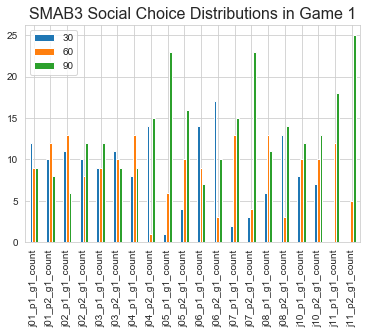

In [323]:
'''Here we place all of the data into the number of times each subject chose each hole into dataframes for games 1 
and 2. We plot this data and run statistics on it.'''

# # Joint combined choices in G1



j_g1_counts = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count'])


# In[ ]:


j_g1_counts = j_g1_counts.fillna(0)


# In[ ]:


j_g1_counts 


# In[ ]:


j_g1_counts.sum(axis=1)


# In[ ]:


j_g1_counts_bar = j_g1_counts.plot.bar()

j_g1_counts_bar.axes.set_title("SMAB3 Social Choice Distributions in Game 1",
                    fontsize=16)

j_g1_counts_bar.figure.savefig("j_g1_counts_bar.jpg",
                    format='jpeg')

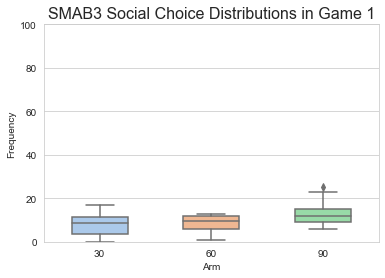

In [170]:
# In[ ]:
sns.set_style("whitegrid")

j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"
 
plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')


# In[ ]:

In [171]:
j_g1_low = np.mean(j_g1_counts.iloc[:,0])
j_g1_med = np.mean(j_g1_counts.iloc[:,1])
j_g1_high = np.mean(j_g1_counts.iloc[:,2])


# In[ ]:


j_g1_low


# In[ ]:


j_g1_med


# In[ ]:


j_g1_high


# In[ ]:


j_g1_low_std = np.std(j_g1_counts.iloc[:,0])
j_g1_med_std = np.std(j_g1_counts.iloc[:,1])
j_g1_high_std = np.std(j_g1_counts.iloc[:,2])


# In[ ]:


j_g1_low_std


# In[ ]:


j_g1_med_std


# In[ ]:


j_g1_high_std

5.284647575761321

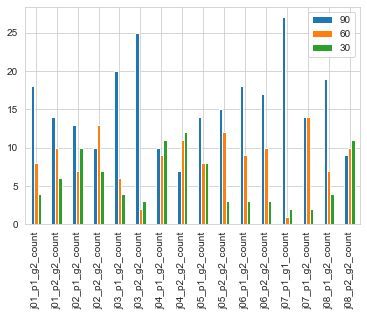

In [172]:
# # Joint combined choices in G2


j_g2_d_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g1_count', 'j07_p1_g2_count', 
                 'j08_p1_g2_count', 'j08_p2_g2_count'])



j_g2_d_counts = j_g2_d_counts.fillna(0)



j_g2_d_counts.sum(axis=1)



j_g2_d_counts_bar = j_g2_d_counts.plot.bar()

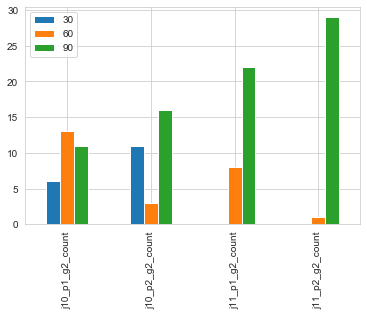

In [173]:
j_g2_s_counts = pd.DataFrame([j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count],
                index = ['j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count'])



j_g2_s_counts = j_g2_s_counts.fillna(0)



j_g2_s_counts.sum(axis=1)



j_g2_s_counts_bar = j_g2_s_counts.plot.bar()

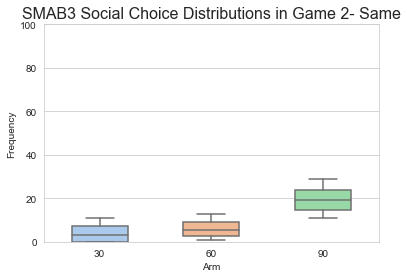

In [174]:
# In[ ]:


j_g2_s_counts_box = sns.boxplot( 
                 data=j_g2_s_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_s_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 2- Same",
                    fontsize=16)

plot_file_name="j_g2_s_counts_box.jpg"
 
plt.ylim(0, 100)
j_g2_s_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

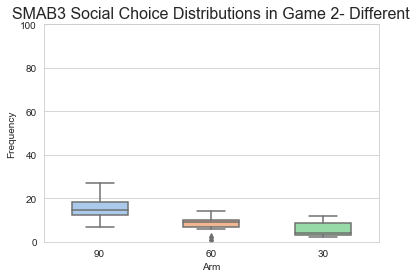

In [175]:
j_g2_d_counts_box = sns.boxplot( 
                 data=j_g2_d_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_d_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 2- Different",
                    fontsize=16)

plot_file_name="j_g2_d_counts_box.jpg"
 
plt.ylim(0, 100)
j_g2_d_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [176]:
j_scores_1

,score_1
participant,
j01_p1,57
j01_p2,61
j02_p1,54
j02_p2,68
j03_p1,69
j03_p2,67
j04_p1,64
j04_p2,56
j05_p1,77


In [177]:
j_scores_1_mean

score_1    66.85
dtype: float64

In [178]:
j_scores_1_std

score_1    9.653333
dtype: float64

In [179]:
# In[ ]:

j_g1_low = np.mean(j_g1_counts.iloc[:,0])
j_g1_med = np.mean(j_g1_counts.iloc[:,1])
j_g1_high = np.mean(j_g1_counts.iloc[:,2])

j_g2_s_low = np.mean(j_g2_s_counts.iloc[:,0])
j_g2_s_med = np.mean(j_g2_s_counts.iloc[:,1])
j_g2_s_high = np.mean(j_g2_s_counts.iloc[:,2])

j_g2_d_low = np.mean(j_g2_d_counts.iloc[:,0])
j_g2_d_med = np.mean(j_g2_d_counts.iloc[:,1])
j_g2_d_high = np.mean(j_g2_d_counts.iloc[:,2])

In [180]:
j_g1_low, j_g1_med, j_g1_high

(8.0, 8.65, 13.35)

In [181]:
j_g1_low_std, j_g1_med_std, j_g1_high_std

(4.898979485566356, 3.6779749863205975, 5.284647575761321)

In [182]:
j_g1_counts

,30,60,90
j01_p1_g1_count,12.0,9.0,9.0
j01_p2_g1_count,10.0,12.0,8.0
j02_p1_g1_count,11.0,13.0,6.0
j02_p2_g1_count,10.0,8.0,12.0
j03_p1_g1_count,9.0,9.0,12.0
j03_p2_g1_count,11.0,10.0,9.0
j04_p1_g1_count,8.0,13.0,9.0
j04_p2_g1_count,14.0,1.0,15.0
j05_p1_g1_count,1.0,6.0,23.0
j05_p2_g1_count,4.0,10.0,16.0


# Reaction Time

In [183]:
'Here we get the reaction times'
time_j_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_j_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [184]:
time_j_1 = reaction_time(j01_p1_g1, time_j_1)
time_j_1 = reaction_time(j02_p1_g1, time_j_1)
time_j_1 = reaction_time(j03_p1_g1, time_j_1)
time_j_1 = reaction_time(j04_p1_g1, time_j_1)
time_j_1 = reaction_time(j05_p1_g1, time_j_1)
time_j_1 = reaction_time(j06_p1_g1, time_j_1)
time_j_1 = reaction_time(j07_p1_g1, time_j_1)
time_j_1 = reaction_time(j08_p1_g1, time_j_1)
time_j_1 = reaction_time(j10_p1_g1, time_j_1)
time_j_1 = reaction_time(j11_p1_g1, time_j_1)

In [185]:
time_j_2 = reaction_time(j01_p1_g2, time_j_2)
time_j_2 = reaction_time(j02_p1_g2, time_j_2)
time_j_2 = reaction_time(j03_p1_g2, time_j_2)
time_j_2 = reaction_time(j04_p1_g2, time_j_2)
time_j_2 = reaction_time(j05_p1_g2, time_j_2)
time_j_2 = reaction_time(j06_p1_g2, time_j_2)
time_j_2 = reaction_time(j07_p1_g2, time_j_2)
time_j_2 = reaction_time(j08_p1_g2, time_j_2)
time_j_2 = reaction_time(j10_p1_g2, time_j_2)
time_j_2 = reaction_time(j11_p1_g2, time_j_2)

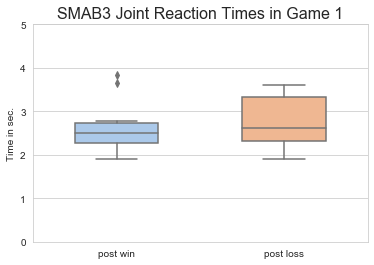

In [186]:
times_j_g1_box = sns.boxplot( 
                 data=time_j_1, 
                 width=0.5,
                 palette="pastel")
times_j_g1_box.axes.set_title("SMAB3 Joint Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_j_g1_box.jpg"
 
plt.ylim(0, 5)
times_j_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_j_g1_box.figure.savefig(plot_file_name,format='jpeg')

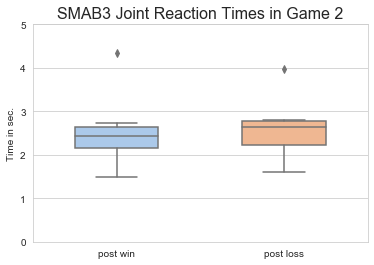

In [187]:
times_j_g2_box = sns.boxplot( 
                 data=time_j_2, 
                 width=0.5,
                 palette="pastel")
times_j_g2_box.axes.set_title("SMAB3 Joint Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_j_g2_box.jpg"
 
plt.ylim(0, 5)
times_j_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_j_g2_box.figure.savefig(plot_file_name,format='jpeg')

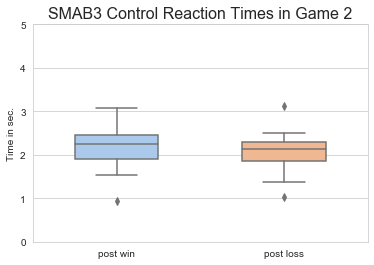

In [188]:
times_s_g2_box = sns.boxplot( 
                 data=time_s_2, 
                 width=0.5,
                 palette="pastel")
times_s_g2_box.axes.set_title("SMAB3 Control Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_s_g2_box.jpg"
 
plt.ylim(0, 5)
times_s_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_s_g2_box.figure.savefig(plot_file_name,format='jpeg')

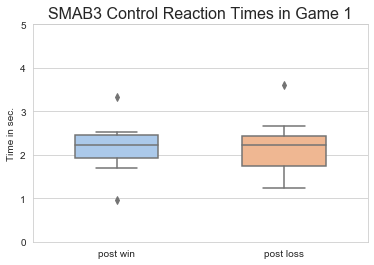

In [189]:
times_s_g1_box = sns.boxplot( 
                 data=time_s_1, 
                 width=0.5,
                 palette="pastel")
times_s_g1_box.axes.set_title("SMAB3 Control Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_s_g1_box.jpg"
 
plt.ylim(0, 5)
times_s_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_s_g1_box.figure.savefig(plot_file_name,format='jpeg')

In [190]:
np.mean(time_s_1)

post win     2.177116
post loss    2.181738
dtype: float64

In [191]:
np.mean(time_s_2)

post win     2.118549
post loss    2.049547
dtype: float64

In [192]:
np.std(time_s_1)

post win     0.528221
post loss    0.578885
dtype: float64

In [193]:
np.std(time_s_2)

post win     0.536611
post loss    0.528770
dtype: float64

In [194]:
np.mean(time_j_1)

post win     2.629908
post loss    2.741026
dtype: float64

In [195]:
np.mean(time_j_2)

post win     2.517012
post loss    2.860335
dtype: float64

In [196]:
np.std(time_j_1)

post win     0.615928
post loss    0.602834
dtype: float64

In [197]:
np.std(time_j_2)

post win     0.700845
post loss    1.015839
dtype: float64

In [198]:
sp.stats.ttest_rel(time_s_1['post win'],time_s_1['post loss'])

Ttest_relResult(statistic=nan, pvalue=nan)

In [199]:
sp.stats.ttest_rel(time_s_2['post win'],time_s_2['post loss'])

Ttest_relResult(statistic=1.136343499564463, pvalue=0.2799632807606969)

In [200]:
sp.stats.ttest_rel(time_j_1['post win'],time_j_1['post loss'])

Ttest_relResult(statistic=-1.1418218122546244, pvalue=0.28299596788547354)

In [201]:
sp.stats.ttest_rel(time_j_2['post win'],time_j_2['post loss'])

Ttest_relResult(statistic=-1.1131872945793573, pvalue=0.2944746024410398)

# SMAB4 Joint Data 

In [202]:
'''Here we load the csv files into pandas dataframes by calling organize_trial_by_trial and get the scores in games
1 and 2 by calling call_get_score.
Note: for the files that were hand coded, the scores will be obtained later, as the score column needs to be filled out still.'''

# # Multi Analysis

#df = organize_trial_by_trial_hand_code2('data/m01_gamedata_handcode.csv')
#m01 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
#m01.head()

#df = organize_trial_by_trial_hand_code2('data/m03_gamedata_handcode.csv')
#m03 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
#m03.head()

df = organize_trial_by_trial('data/m05_gamedata.csv')
m05 = df
m05_p1_g1_score,m05_p1_g2_score,m05_p2_g1_score,m05_p2_g2_score,m05_p1_diff,m05_p2_diff,m05_p1_g1_50,m05_p1_g2_50,m05_p2_g1_50,m05_p2_g2_50 = call_get_score(m05, 'm')
m05.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m06_gamedata2.csv')
m06 = df
m06_p1_g1_score,m06_p1_g2_score,m06_p2_g1_score,m06_p2_g2_score,m06_p1_diff,m06_p2_diff,m06_p1_g1_50,m06_p1_g2_50,m06_p2_g1_50,m06_p2_g2_50 = call_get_score(m06, 'm')
m06.head()


#df = organize_trial_by_trial_hand_code2('data/m07_gamedata_handcode.csv')
#m07 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
#m07.head()

#m09 from LSL needs to be combined with hand coded
#df = organize_trial_by_trial_hand_code('data/m09_gamedata_handcode.csv')
#m09 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
#m09.head()

#df = organize_trial_by_trial('data/m09_gamedata.csv')
#m09_lsl = df
#m09_p1_g1_score,m09_p1_g2_score,m09_p2_g1_score,m09_p2_g2_score,m09_p1_diff,m09_p2_diff,m09_p1_g1_50,m09_p1_g2_50,m09_p2_g1_50,m09_p2_g2_50 = call_get_score(m09, 'm')
#m09.head()

df = organize_trial_by_trial_300('data/m08_gamedata2.csv')
m08 = df
m08_p1_g1_score,m08_p1_g2_score,m08_p2_g1_score,m08_p2_g2_score,m08_p1_diff,m08_p2_diff,m08_p1_g1_50,m08_p1_g2_50,m08_p2_g1_50,m08_p2_g2_50 = call_get_score(m08, 'm')
m08.head()


# In[ ]:


# In[ ]:


df = organize_trial_by_trial_300('data/m10_gamedata2.csv')
m10 = df
m10_p1_g1_score,m10_p1_g2_score,m10_p2_g1_score,m10_p2_g2_score,m10_p1_diff,m10_p2_diff,m10_p1_g1_50,m10_p1_g2_50,m10_p2_g1_50,m10_p2_g2_50 = call_get_score(m10, 'm')
m10.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m11_gamedata2.csv')
m11 = df
m11_p1_g1_score,m11_p1_g2_score,m11_p2_g1_score,m11_p2_g2_score,m11_p1_diff,m11_p2_diff,m11_p1_g1_50,m11_p1_g2_50,m11_p2_g1_50,m11_p2_g2_50 = call_get_score(m11, 'm')
m11.head()


# In[ ]:

#session ends early
#df = organize_trial_by_trial_floatclick('data/m12_gamedata.csv')
#m12 = df
#m12_p1_g1_score,m12_p1_g2_score,m12_p2_g1_score,m12_p2_g2_score,m12_p1_score_diff,m12_p2_score_diff = call_get_score(m12, 'm')
#m12.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m13_gamedata2.csv')
m13 = df
m13_p1_g1_score,m13_p1_g2_score,m13_p2_g1_score,m13_p2_g2_score,m13_p1_diff,m13_p2_diff,m13_p1_g1_50,m13_p1_g2_50,m13_p2_g1_50,m13_p2_g2_50 = call_get_score(m13, 'm')
m13.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m14_gamedata2.csv')
m14 = df
m14_p1_g1_score,m14_p1_g2_score,m14_p2_g1_score,m14_p2_g2_score,m14_p1_diff,m14_p2_diff,m14_p1_g1_50,m14_p1_g2_50,m14_p2_g1_50,m14_p2_g2_50 = call_get_score(m14, 'm')
m14.head()


# In[ ]:


m05_p1_g1, m05_p1_g2, m05_p2_g1, m05_p2_g2 = separate_df(m05, 'm')
m06_p1_g1, m06_p1_g2, m06_p2_g1, m06_p2_g2 = separate_df(m06, 'm')
#m07_p1_g1, m07_p1_g2, m07_p2_g1, m07_p2_g2 = separate_df(m07, 'm')
m08_p1_g1, m08_p1_g2, m08_p2_g1, m08_p2_g2 = separate_df(m08, 'm')
m10_p1_g1, m10_p1_g2, m10_p2_g1, m10_p2_g2 = separate_df(m10, 'm')
m11_p1_g1, m11_p1_g2, m11_p2_g1, m11_p2_g2 = separate_df(m11, 'm')
m13_p1_g1, m13_p1_g2, m13_p2_g1, m13_p2_g2 = separate_df(m13, 'm')

m14_p1_g1, m14_p1_g2, m14_p2_g1, m14_p2_g2 = separate_df(m14, 'm')

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [203]:
m13_p1_g1

,game number,trial,player,arm,probability,reward,time,P1 score,P2 score
20,1,21,1,3,90,1,4.524838,5,5
22,1,23,1,1,30,1,3.596283,6,6
24,1,25,1,3,90,0,4.707752,6,7
26,1,27,1,1,30,0,4.226980,6,8
28,1,29,1,2,60,0,4.341929,6,8
30,1,31,1,3,90,0,4.345925,6,9
32,1,33,1,1,30,1,4.068058,7,10
34,1,35,1,3,90,1,6.244021,8,11
36,1,37,1,2,60,1,5.267478,9,12
38,1,39,1,3,90,1,4.970626,10,13


In [204]:
#m01_p1_counts, m01_p2_counts, m01_p1_probs, m01_p2_probs = handcode_calc_prob(m01)
#m03_p1_counts, m03_p2_counts, m03_p1_probs, m03_p2_probs = handcode_calc_prob(m03)
#m07_p1_counts, m07_p2_counts, m07_p1_probs, m07_p2_probs = handcode_calc_prob(m07)

In [205]:
#m01_p1_g1, m01_p1_g2, m01_p2_g1, m01_p2_g2 = separate_df(m01, 'm')
#m03_p1_g1, m03_p1_g2, m03_p2_g1, m03_p2_g2 = separate_df(m03, 'm')
#m07_p1_g1, m07_p1_g2, m07_p2_g1, m07_p2_g2 = separate_df(m07, 'm')

In [206]:
'''Here we check the probability-hole mappings for each player in each game'''
#INDEXOR ERROR

'''m01_p1_g1_map = hole_prob_map(m01_p1_g1)
m01_p1_g2_map = hole_prob_map(m01_p1_g2)
m01_p2_g1_map = hole_prob_map(m01_p2_g1)

m03_p2_g2_map = hole_prob_map(m03_p2_g2)
m03_p1_g1_map = hole_prob_map(m03_p1_g1)
m03_p1_g2_map = hole_prob_map(m03_p1_g2)
m03_p2_g1_map = hole_prob_map(m03_p2_g1)
m03_p2_g2_map = hole_prob_map(m03_p2_g2)

m05_p1_g1_map = hole_prob_map(m05_p1_g1)
m05_p1_g2_map = hole_prob_map(m05_p1_g2)
m05_p2_g1_map = hole_prob_map(m05_p2_g1)
m05_p2_g2_map = hole_prob_map(m05_p2_g2)

m06_p1_g1_map = hole_prob_map(m06_p1_g1)
m06_p1_g2_map = hole_prob_map(m06_p1_g2)
m06_p2_g1_map = hole_prob_map(m06_p2_g1)
m06_p2_g2_map = hole_prob_map(m06_p2_g2)

m07_p1_g1_map = hole_prob_map(m07_p1_g1)
#m07_p1_g2_map = hole_prob_map(m07_p1_g2)
m07_p2_g1_map = hole_prob_map(m07_p2_g1)
#m07_p2_g2_map = hole_prob_map(m07_p2_g2)

m08_p1_g1_map = hole_prob_map(m08_p1_g1)
m08_p1_g2_map = hole_prob_map(m08_p1_g2)
m08_p2_g1_map = hole_prob_map(m08_p2_g1)
m08_p2_g2_map = hole_prob_map(m08_p2_g2)

m10_p1_g1_map = hole_prob_map(m10_p1_g1)
m10_p1_g2_map = hole_prob_map(m10_p1_g2)
m10_p2_g1_map = hole_prob_map(m10_p2_g1)
m10_p2_g2_map = hole_prob_map(m10_p2_g2)

m11_p1_g1_map = hole_prob_map(m11_p1_g1)
#m11_p1_g2_map = hole_prob_map(m11_p1_g2)
m11_p2_g1_map = hole_prob_map(m11_p2_g1)
#m11_p2_g2_map = hole_prob_map(m11_p2_g2)

m13_p1_g1_map = hole_prob_map(m13_p1_g1)
m13_p1_g2_map = hole_prob_map(m13_p1_g2)
m13_p2_g1_map = hole_prob_map(m13_p2_g1)
m13_p2_g2_map = hole_prob_map(m13_p2_g2)'''

'm01_p1_g1_map = hole_prob_map(m01_p1_g1)\nm01_p1_g2_map = hole_prob_map(m01_p1_g2)\nm01_p2_g1_map = hole_prob_map(m01_p2_g1)\n\nm03_p2_g2_map = hole_prob_map(m03_p2_g2)\nm03_p1_g1_map = hole_prob_map(m03_p1_g1)\nm03_p1_g2_map = hole_prob_map(m03_p1_g2)\nm03_p2_g1_map = hole_prob_map(m03_p2_g1)\nm03_p2_g2_map = hole_prob_map(m03_p2_g2)\n\nm05_p1_g1_map = hole_prob_map(m05_p1_g1)\nm05_p1_g2_map = hole_prob_map(m05_p1_g2)\nm05_p2_g1_map = hole_prob_map(m05_p2_g1)\nm05_p2_g2_map = hole_prob_map(m05_p2_g2)\n\nm06_p1_g1_map = hole_prob_map(m06_p1_g1)\nm06_p1_g2_map = hole_prob_map(m06_p1_g2)\nm06_p2_g1_map = hole_prob_map(m06_p2_g1)\nm06_p2_g2_map = hole_prob_map(m06_p2_g2)\n\nm07_p1_g1_map = hole_prob_map(m07_p1_g1)\n#m07_p1_g2_map = hole_prob_map(m07_p1_g2)\nm07_p2_g1_map = hole_prob_map(m07_p2_g1)\n#m07_p2_g2_map = hole_prob_map(m07_p2_g2)\n\nm08_p1_g1_map = hole_prob_map(m08_p1_g1)\nm08_p1_g2_map = hole_prob_map(m08_p1_g2)\nm08_p2_g1_map = hole_prob_map(m08_p2_g1)\nm08_p2_g2_map = hole_

In [207]:
'''m01_p1_g1_score = m01_p1_g1['reward'].sum()
m01_p1_g2_score = m01_p1_g2['reward'].sum()
m01_p2_g1_score = m01_p2_g1['reward'].sum()
m01_p2_g2_score = m01_p2_g2['reward'].sum()

m03_p1_g1_score = m03_p1_g1['reward'].sum()
m03_p1_g2_score = m03_p1_g2['reward'].sum()
m03_p2_g1_score = m03_p2_g1['reward'].sum()
m03_p2_g2_score = m03_p2_g2['reward'].sum()

m07_p1_g1_score = m07_p1_g1['reward'].sum()
m07_p1_g2_score = m07_p1_g2['reward'].sum()
m07_p2_g1_score = m07_p2_g1['reward'].sum()
m07_p2_g2_score = m07_p2_g2['reward'].sum()'''

"m01_p1_g1_score = m01_p1_g1['reward'].sum()\nm01_p1_g2_score = m01_p1_g2['reward'].sum()\nm01_p2_g1_score = m01_p2_g1['reward'].sum()\nm01_p2_g2_score = m01_p2_g2['reward'].sum()\n\nm03_p1_g1_score = m03_p1_g1['reward'].sum()\nm03_p1_g2_score = m03_p1_g2['reward'].sum()\nm03_p2_g1_score = m03_p2_g1['reward'].sum()\nm03_p2_g2_score = m03_p2_g2['reward'].sum()\n\nm07_p1_g1_score = m07_p1_g1['reward'].sum()\nm07_p1_g2_score = m07_p1_g2['reward'].sum()\nm07_p2_g1_score = m07_p2_g1['reward'].sum()\nm07_p2_g2_score = m07_p2_g2['reward'].sum()"

In [208]:
# In[ ]:
#Not working for m01 and m07 (hand coded)- need to fill in the probability column
'''m01_p1_g1_count = m01_p1_g1['probability'].value_counts(sort=False)
m01_p1_g2_count = m01_p1_g2['probability'].value_counts(sort=False)
m01_p2_g1_count = m01_p2_g1['probability'].value_counts(sort=False)
m01_p2_g2_count = m01_p2_g2['probability'].value_counts(sort=False)
m03_p1_g1_count = m03_p1_g1['probability'].value_counts(sort=False)
m03_p1_g2_count = m03_p1_g2['probability'].value_counts(sort=False)
m03_p2_g1_count = m03_p2_g1['probability'].value_counts(sort=False)
m03_p2_g2_count = m03_p2_g2['probability'].value_counts(sort=False)

m05_p1_g1_count = m05_p1_g1['probability'].value_counts(sort=False)
m05_p1_g2_count = m05_p1_g2['probability'].value_counts(sort=False)
m05_p2_g1_count = m05_p2_g1['probability'].value_counts(sort=False)
m05_p2_g2_count = m05_p2_g2['probability'].value_counts(sort=False)

m07_p1_g1_count = m07_p1_g1['probability'].value_counts(sort=False)
m07_p1_g2_count = m07_p1_g2['probability'].value_counts(sort=False)
m07_p2_g1_count = m07_p2_g1['probability'].value_counts(sort=False)
m07_p2_g2_count = m07_p2_g2['probability'].value_counts(sort=False)'''

"m01_p1_g1_count = m01_p1_g1['probability'].value_counts(sort=False)\nm01_p1_g2_count = m01_p1_g2['probability'].value_counts(sort=False)\nm01_p2_g1_count = m01_p2_g1['probability'].value_counts(sort=False)\nm01_p2_g2_count = m01_p2_g2['probability'].value_counts(sort=False)\nm03_p1_g1_count = m03_p1_g1['probability'].value_counts(sort=False)\nm03_p1_g2_count = m03_p1_g2['probability'].value_counts(sort=False)\nm03_p2_g1_count = m03_p2_g1['probability'].value_counts(sort=False)\nm03_p2_g2_count = m03_p2_g2['probability'].value_counts(sort=False)\n\nm05_p1_g1_count = m05_p1_g1['probability'].value_counts(sort=False)\nm05_p1_g2_count = m05_p1_g2['probability'].value_counts(sort=False)\nm05_p2_g1_count = m05_p2_g1['probability'].value_counts(sort=False)\nm05_p2_g2_count = m05_p2_g2['probability'].value_counts(sort=False)\n\nm07_p1_g1_count = m07_p1_g1['probability'].value_counts(sort=False)\nm07_p1_g2_count = m07_p1_g2['probability'].value_counts(sort=False)\nm07_p2_g1_count = m07_p2_g1['

In [209]:
#same_probs_g1_2
m05_p1_g1_count = m05_p1_g1['probability'].value_counts(sort=False)
m05_p1_g2_count = m05_p1_g2['probability'].value_counts(sort=False)
m05_p2_g1_count = m05_p2_g1['probability'].value_counts(sort=False)
m05_p2_g2_count = m05_p2_g2['probability'].value_counts(sort=False)
m06_p1_g1_count = m06_p1_g1['probability'].value_counts(sort=False)
m06_p1_g2_count = m06_p1_g2['probability'].value_counts(sort=False)
m06_p2_g1_count = m06_p2_g1['probability'].value_counts(sort=False)
m06_p2_g2_count = m06_p2_g2['probability'].value_counts(sort=False)
#m07_p1_g1_count = m07_p1_g1['probability'].value_counts(sort=False)
#m07_p1_g2_count = m07_p1_g2['probability'].value_counts(sort=False)
#m07_p2_g1_count = m07_p2_g1['probability'].value_counts(sort=False)
#m07_p2_g2_count = m07_p2_g2['probability'].value_counts(sort=False)
m08_p1_g1_count = m08_p1_g1['probability'].value_counts(sort=False)
m08_p1_g2_count = m08_p1_g2['probability'].value_counts(sort=False)
m08_p2_g1_count = m08_p2_g1['probability'].value_counts(sort=False)
m08_p2_g2_count = m08_p2_g2['probability'].value_counts(sort=False)
m10_p1_g1_count = m10_p1_g1['probability'].value_counts(sort=False)
m10_p1_g2_count = m10_p1_g2['probability'].value_counts(sort=False)
m10_p2_g1_count = m10_p2_g1['probability'].value_counts(sort=False)
m10_p2_g2_count = m10_p2_g2['probability'].value_counts(sort=False)
m11_p1_g1_count = m11_p1_g1['probability'].value_counts(sort=False)
m11_p1_g2_count = m11_p1_g2['probability'].value_counts(sort=False)
m11_p2_g1_count = m11_p2_g1['probability'].value_counts(sort=False)
m11_p2_g2_count = m11_p2_g2['probability'].value_counts(sort=False)
m13_p1_g1_count = m13_p1_g1['probability'].value_counts(sort=False)
m13_p1_g2_count = m13_p1_g2['probability'].value_counts(sort=False)
m13_p2_g1_count = m13_p2_g1['probability'].value_counts(sort=False)
m13_p2_g2_count = m13_p2_g2['probability'].value_counts(sort=False)
m14_p1_g1_count = m14_p1_g1['probability'].value_counts(sort=False)
m14_p1_g2_count = m14_p1_g2['probability'].value_counts(sort=False)
m14_p2_g1_count = m14_p2_g1['probability'].value_counts(sort=False)
m14_p2_g2_count = m14_p2_g2['probability'].value_counts(sort=False)

In [210]:
#call fix_reward on all of the files imported with '300' to fix the reward column
m06_p1_g1 = fix_reward(m06_p1_g1)
m06_p1_g2 = fix_reward(m06_p1_g2)
m06_p2_g1 = fix_reward(m06_p2_g1)
m06_p2_g2 = fix_reward(m06_p2_g2)
m08_p1_g1 = fix_reward(m08_p1_g1)
m08_p1_g2 = fix_reward(m08_p1_g2)
m08_p2_g1 = fix_reward(m08_p2_g1)
m08_p2_g2 = fix_reward(m08_p2_g2)
m10_p1_g1 = fix_reward(m10_p1_g1)
m10_p1_g2 = fix_reward(m10_p1_g2)
m10_p2_g1 = fix_reward(m10_p2_g1)
m10_p2_g2 = fix_reward(m10_p2_g2)
m11_p1_g1 = fix_reward(m11_p1_g1)
m11_p1_g2 = fix_reward(m11_p1_g2)
m11_p2_g1 = fix_reward(m11_p2_g1)
m11_p2_g2 = fix_reward(m11_p2_g2)
m13_p1_g1 = fix_reward(m13_p1_g1)
m13_p1_g2 = fix_reward(m13_p1_g2)
m13_p2_g1 = fix_reward(m13_p2_g1)
m13_p2_g2 = fix_reward(m13_p2_g2)
m14_p1_g1 = fix_reward(m14_p1_g1)
m14_p1_g2 = fix_reward(m14_p1_g2)
m14_p2_g1 = fix_reward(m14_p2_g1)
m14_p2_g2 = fix_reward(m14_p2_g2)

In [211]:
# # Combined multi scores G1

# In[ ]:

m_scores_1 = pd.DataFrame({'participant':['m05_p1', 'm05_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1':
     [m05_p1_g1_score, m05_p2_g1_score, m08_p1_g1_score, m08_p2_g1_score,
      m10_p1_g1_score, m10_p2_g1_score, m11_p1_g1_score, m11_p2_g1_score, m13_p1_g1_score, m13_p2_g1_score,
      m14_p1_g1_score, m14_p2_g1_score]})
m_scores_1.set_index('participant', inplace=True, drop=True)
m_scores_1

,score_1
participant,
m05_p1,86
m05_p2,75
m08_p1,69
m08_p2,83
m10_p1,69
m10_p2,57
m11_p1,80
m11_p2,87
m13_p1,53


In [212]:
# # Combined multi scores G2

# In[ ]:

#NEEDS TO BE SEPARATED
m_scores_2_d = pd.DataFrame({'participant':['m05_p1','m05_p2'], 'score_2':
     [m05_p1_g2_score, m05_p2_g2_score]})
m_scores_2_d.set_index('participant', inplace=True, drop=True)

m_scores_2_s = pd.DataFrame({'participant':['m08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_2':
     [m08_p1_g2_score, m08_p2_g2_score,
      m10_p1_g2_score, m10_p2_g2_score, m11_p1_g2_score, m11_p2_g2_score, m13_p1_g2_score, m13_p2_g2_score,
      m14_p1_g2_score, m14_p2_g2_score]})
m_scores_2_s.set_index('participant', inplace=True, drop=True)


#NEEDS TO BE REVISITED, add 50 to hand coded sessions
'''m_scores_1_50 = pd.DataFrame({'participant':['m01_p1','m01_p2', 'm03_p1', 'm03_p2','m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':
     [m01_p1_g1_50, m01_p2_g1_50, m03_p1_g1_50, m03_p2_g1_50, m05_p1_g1_50, m05_p2_g1_50, m06_p1_g1_50, m06_p2_g1_50, m07_p1_g1_50, m07_p2_g1_50, m08_p1_g1_50, m08_p2_g1_50, m10_p1_g1_50, m10_p2_g1_50, m11_p1_g1_50, m11_p2_g1_50, m13_p1_g1_50, m13_p2_g1_50,
     m14_p1_g1_50, m14_p2_g1_50,]})
m_scores_1_50.set_index('participant', inplace=True, drop=True)'''

#NEEDS TO BE SEPARATED
m_scores_2_50 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':
     [m05_p1_g2_50, m05_p2_g2_50, m06_p1_g2_50, m06_p2_g2_50, m08_p1_g2_50, m08_p2_g2_50, m10_p1_g2_50, m10_p2_g2_50, m11_p1_g2_50, m11_p2_g2_50, m13_p1_g2_50, m13_p2_g2_50,
     m14_p1_g2_50, m14_p2_g2_50,]})
m_scores_2_50.set_index('participant', inplace=True, drop=True)

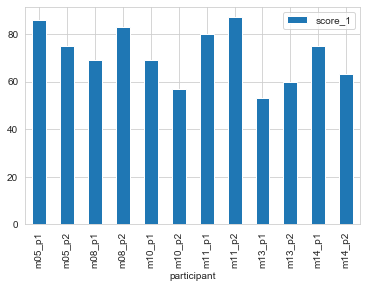

In [213]:
m_scores_1_bar = m_scores_1.plot.bar()

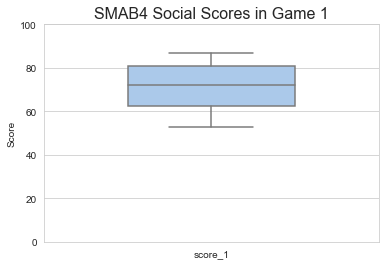

In [214]:
m_g1_scores_box = sns.boxplot( 
                 data=m_scores_1, 
                 width=0.5,
                 palette="pastel")
m_g1_scores_box.axes.set_title("SMAB4 Social Scores in Game 1",
                    fontsize=16)

plot_file_name="m_g1_score_box.jpg"
 
plt.ylim(0, 100)
m_g1_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g1_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')


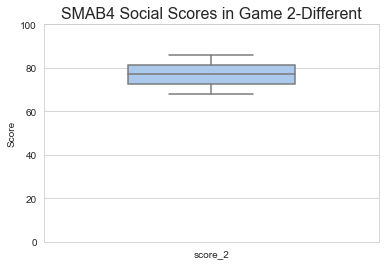

In [215]:
m_g2d_scores_box = sns.boxplot( 
                 data=m_scores_2_d, 
                 width=0.5,
                 palette="pastel")
m_g2d_scores_box.axes.set_title("SMAB4 Social Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="m_g2d_score_box.jpg"
 
plt.ylim(0, 100)
m_g2d_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g2d_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

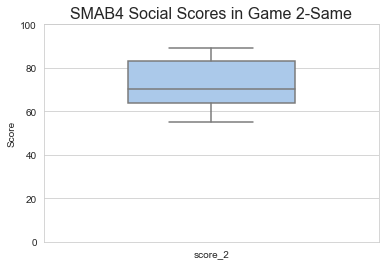

In [216]:
m_g2s_scores_box = sns.boxplot( 
                 data=m_scores_2_s, 
                 width=0.5,
                 palette="pastel")
m_g2s_scores_box.axes.set_title("SMAB4 Social Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="m_g2s_score_box.jpg"
 
plt.ylim(0, 100)
m_g2s_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g2s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [217]:
m_scores_2s_mean = m_scores_2_s.mean()

In [218]:
m_scores_2s_std = m_scores_2_s.std()

In [219]:
m_scores_2d_mean = m_scores_2_d.mean()

In [220]:
m_scores_2d_std = m_scores_2_d.std()

In [221]:
m_scores_2s_mean, m_scores_2s_std

(score_2    72.5
 dtype: float64, score_2    12.49222
 dtype: float64)

In [222]:
m_scores_2d_mean, m_scores_2d_std

(score_2    77.0
 dtype: float64, score_2    12.727922
 dtype: float64)

In [223]:
sp.stats.ttest_ind(m_scores_2_s, m_scores_2_d)

Ttest_indResult(statistic=array([-0.46416425]), pvalue=array([0.65247024]))

# COMPLETE MULTIPLAYER CHOICE DIST

In [358]:
'''Here we place the counts of how many times each hole was chosen into dataframes for games 1 and 2. We also 
get statistics on this data and plot it.'''

# # Multi combined choices in G1

# In[ ]:


m_g1_counts = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count, m05_p1_g1_count, m05_p2_g1_count, m08_p1_g1_count, m08_p2_g1_count, 
              m10_p1_g1_count, m10_p2_g1_count, m11_p1_g1_count, m11_p2_g1_count, m13_p1_g1_count, m13_p2_g1_count, 
              m14_p1_g1_count, m14_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count', 'm05_p1_g1_count', 'm05_p2_g1_count', 
                'm08_p1_g1_count', 'm08_p2_g1_count', 'm10_p1_g1_count', 'm10_p2_g1_count', 'm11_p1_g1_count', 
                'm11_p2_g1_count', 'm13_p1_g1_count', 'm13_p2_g1_count', 'm14_p1_g1_count', 'm14_p2_g1_count']) 






# In[ ]:


m_g1_counts = m_g1_counts.fillna(0) 



# In[ ]:


m_g1_counts


# In[ ]:


m_g1_counts.sum(axis=1)


# In[ ]:

# save as jpeg




j01_p1_g1_count    30.0
j01_p2_g1_count    30.0
j02_p1_g1_count    30.0
j02_p2_g1_count    30.0
j03_p1_g1_count    30.0
j03_p2_g1_count    30.0
j04_p1_g1_count    30.0
j04_p2_g1_count    30.0
j05_p1_g1_count    30.0
j05_p2_g1_count    30.0
j06_p1_g1_count    30.0
j06_p2_g1_count    30.0
j07_p1_g1_count    30.0
j07_p2_g1_count    30.0
j08_p1_g1_count    30.0
j08_p2_g1_count    30.0
j10_p1_g1_count    30.0
j10_p2_g1_count    30.0
j11_p1_g1_count    30.0
j11_p2_g1_count    30.0
m05_p1_g1_count    30.0
m05_p2_g1_count    30.0
m08_p1_g1_count    30.0
m08_p2_g1_count    30.0
m10_p1_g1_count    30.0
m10_p2_g1_count    30.0
m11_p1_g1_count    30.0
m11_p2_g1_count    30.0
m13_p1_g1_count    30.0
m13_p2_g1_count    30.0
m14_p1_g1_count    30.0
m14_p2_g1_count    30.0
dtype: float64

In [359]:
m_g1_counts

,30,60,90
j01_p1_g1_count,12.0,9.0,9.0
j01_p2_g1_count,10.0,12.0,8.0
j02_p1_g1_count,11.0,13.0,6.0
j02_p2_g1_count,10.0,8.0,12.0
j03_p1_g1_count,9.0,9.0,12.0
j03_p2_g1_count,11.0,10.0,9.0
j04_p1_g1_count,8.0,13.0,9.0
j04_p2_g1_count,14.0,1.0,15.0
j05_p1_g1_count,1.0,6.0,23.0
j05_p2_g1_count,4.0,10.0,16.0


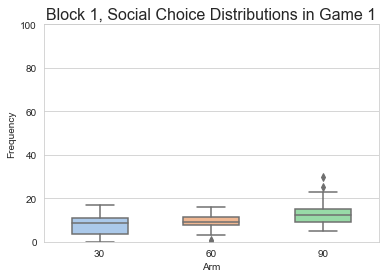

In [360]:
# In[ ]:


m_g1_counts_box = sns.boxplot( 
                 data = m_g1_counts, 
                 width=0.5,
                 palette="pastel")
m_g1_counts_box.axes.set_title("Block 1, Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="m_g1_counts_box.jpg"
 
plt.ylim(0, 100)
m_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [361]:
# # Multi combined choices in G2


m_g2_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count, 
              j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count, m05_p1_g2_count, m05_p2_g2_count, m08_p1_g2_count, m08_p2_g2_count, 
              m10_p1_g2_count, m10_p2_g2_count, m11_p1_g2_count, m11_p2_g2_count, m13_p1_g2_count, m13_p2_g2_count, 
              m14_p1_g2_count, m14_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g2_count', 
                    'j07_p2_g2_count', 'j08_p1_g2_count', 'j08_p2_g2_count', 'j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count', 'm05_p1_g2_count', 'm05_p2_g2_count', 
                'm08_p1_g2_count', 'm08_p2_g2_count', 'm10_p1_g2_count', 'm10_p2_g2_count', 'm11_p1_g2_count', 
                'm11_p2_g2_count', 'm13_p1_g2_count', 'm13_p2_g2_count', 'm14_p1_g2_count', 'm14_p2_g2_count']) 




m_g2_counts = m_g2_counts.fillna(0) 



m_g2_counts.sum(axis=1)

j01_p1_g2_count    30.0
j01_p2_g2_count    30.0
j02_p1_g2_count    30.0
j02_p2_g2_count    30.0
j03_p1_g2_count    30.0
j03_p2_g2_count    30.0
j04_p1_g2_count    30.0
j04_p2_g2_count    30.0
j05_p1_g2_count    30.0
j05_p2_g2_count    30.0
j06_p1_g2_count    30.0
j06_p2_g2_count    30.0
j07_p1_g2_count    30.0
j07_p2_g2_count    30.0
j08_p1_g2_count    30.0
j08_p2_g2_count    30.0
j10_p1_g2_count    30.0
j10_p2_g2_count    30.0
j11_p1_g2_count    30.0
j11_p2_g2_count    30.0
m05_p1_g2_count    30.0
m05_p2_g2_count    30.0
m08_p1_g2_count    30.0
m08_p2_g2_count    30.0
m10_p1_g2_count    30.0
m10_p2_g2_count    30.0
m11_p1_g2_count    30.0
m11_p2_g2_count    30.0
m13_p1_g2_count    30.0
m13_p2_g2_count    30.0
m14_p1_g2_count    30.0
m14_p2_g2_count    30.0
dtype: float64

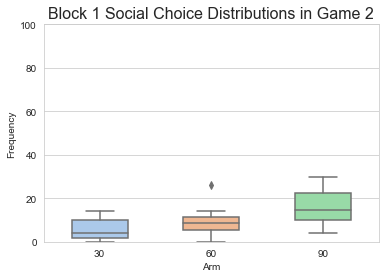

In [362]:
m_g2_counts_box = sns.boxplot( 
                 data = m_g2_counts, 
                 width=0.5,
                 palette="pastel")
m_g2_counts_box.axes.set_title("Block 1 Social Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="m_g2_counts_box.jpg"
 
plt.ylim(0, 100)
m_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [363]:
m_g1_low = np.mean(m_g1_counts.iloc[:,0])
m_g1_med = np.mean(m_g1_counts.iloc[:,1])
m_g1_high = np.mean(m_g1_counts.iloc[:,2])

m_g1_low_std = np.std(m_g1_counts.iloc[:,0])
m_g1_med_std = np.std(m_g1_counts.iloc[:,1])
m_g1_high_std = np.std(m_g1_counts.iloc[:,2])

In [364]:
(m_g1_low, m_g1_med, m_g1_high)

(7.6875, 8.625, 13.6875)

In [365]:
(m_g1_low_std, m_g1_med_std, m_g1_high_std)

(4.713262537775718, 3.950870157319777, 5.719689130538477)

In [366]:
m_g2_low = np.mean(m_g2_counts.iloc[:,0])
m_g2_med = np.mean(m_g2_counts.iloc[:,1])
m_g2_high = np.mean(m_g2_counts.iloc[:,2])

m_g2_low_std = np.std(m_g2_counts.iloc[:,0])
m_g2_med_std = np.std(m_g2_counts.iloc[:,1])
m_g2_high_std = np.std(m_g2_counts.iloc[:,2])

In [367]:
(m_g2_low, m_g2_med, m_g2_high)

(5.5625, 8.0, 16.4375)

In [368]:
(m_g2_low_std, m_g2_med_std, m_g2_high_std)

(4.582149468317244, 5.44288526426931, 7.980200107140171)

In [369]:
sp.stats.ttest_ind(m_g1_counts, m_g2_counts)

Ttest_indResult(statistic=array([ 1.79987745,  0.51740017, -1.55947545]), pvalue=array([0.07674564, 0.60671797, 0.12397421]))

# Reaction Time

In [240]:
'Here we get the reaction times'
time_m_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_m_2 = pd.DataFrame(columns = ['session','post win','post loss'])

time_m_1 = reaction_time(m05_p1_g1, time_m_1)
time_m_1 = reaction_time(m06_p1_g1, time_m_1)
time_m_1 = reaction_time(m08_p1_g1, time_m_1)
time_m_1 = reaction_time(m10_p1_g1, time_m_1)
time_m_1 = reaction_time(m11_p1_g1, time_m_1)
time_m_1 = reaction_time(m13_p1_g1, time_m_1)
time_m_1 = reaction_time(m14_p1_g1, time_m_1)
time_m_1 = reaction_time(m05_p2_g1, time_m_1)
time_m_1 = reaction_time(m06_p2_g1, time_m_1)
time_m_1 = reaction_time(m08_p2_g1, time_m_1)
time_m_1 = reaction_time(m10_p2_g1, time_m_1)
time_m_1 = reaction_time(m11_p2_g1, time_m_1)
time_m_1 = reaction_time(m13_p2_g1, time_m_1)
time_m_1 = reaction_time(m14_p2_g1, time_m_1)

time_m_2 = reaction_time(m05_p1_g2, time_m_2)
time_m_2 = reaction_time(m06_p1_g2, time_m_2)
time_m_2 = reaction_time(m08_p1_g2, time_m_2)
time_m_2 = reaction_time(m10_p1_g2, time_m_2)
time_m_2 = reaction_time(m11_p1_g2, time_m_2)
time_m_2 = reaction_time(m13_p1_g2, time_m_2)
time_m_2 = reaction_time(m14_p1_g2, time_m_2)
time_m_2 = reaction_time(m05_p2_g2, time_m_2)
time_m_2 = reaction_time(m06_p2_g2, time_m_2)
time_m_2 = reaction_time(m08_p2_g2, time_m_2)
time_m_2 = reaction_time(m10_p2_g2, time_m_2)
time_m_2 = reaction_time(m11_p2_g2, time_m_2)
time_m_2 = reaction_time(m13_p2_g2, time_m_2)
time_m_2 = reaction_time(m14_p2_g2, time_m_2)

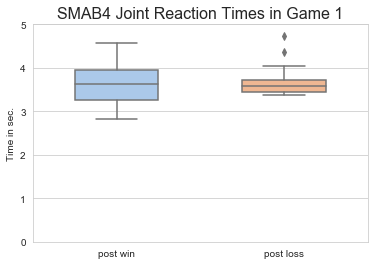

In [241]:
times_m_g1_box = sns.boxplot( 
                 data=time_m_1, 
                 width=0.5,
                 palette="pastel")
times_m_g1_box.axes.set_title("SMAB4 Joint Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_m_g1_box.jpg"
 
plt.ylim(0, 5)
times_m_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_m_g1_box.figure.savefig(plot_file_name,format='jpeg')

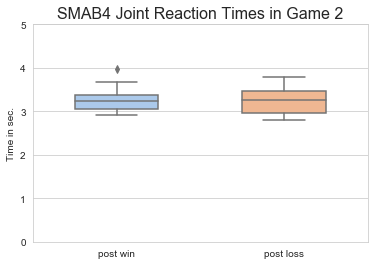

In [242]:
times_m_g2_box = sns.boxplot( 
                 data=time_m_2, 
                 width=0.5,
                 palette="pastel")
times_m_g2_box.axes.set_title("SMAB4 Joint Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_m_g2_box.jpg"
 
plt.ylim(0, 5)
times_m_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_m_g2_box.figure.savefig(plot_file_name,format='jpeg')

In [243]:
np.mean(time_m_1)

post win     3.641789
post loss    3.715743
dtype: float64

In [244]:
np.mean(time_m_2)

post win     3.272778
post loss    3.246691
dtype: float64

In [245]:
np.std(time_m_1)

post win     0.525988
post loss    0.389139
dtype: float64

In [246]:
np.std(time_m_2)

post win     0.282010
post loss    0.320837
dtype: float64

In [247]:
sp.stats.ttest_rel(time_m_1['post win'], time_m_1['post loss'])

Ttest_relResult(statistic=-0.8695721834508444, pvalue=0.40030517597365756)

In [248]:
sp.stats.ttest_rel(time_m_2['post win'], time_m_2['post loss'])

Ttest_relResult(statistic=0.39307880833314035, pvalue=0.7006314687637663)

In [249]:
sp.stats.ttest_rel(time_m_1['post win'], time_m_2['post win'])

Ttest_relResult(statistic=2.195957126298575, pvalue=0.046843975670229555)

In [250]:
sp.stats.ttest_rel(time_m_1['post loss'], time_m_2['post loss'])

Ttest_relResult(statistic=3.848681856174537, pvalue=0.0020125525652778865)

# Test for differences between SMAB3 and SMAB4 in multi-player data

In [251]:
#simple t-test for score 
sp.stats.ttest_ind(m_scores_1, j_scores_1)

Ttest_indResult(statistic=array([1.20725387]), pvalue=array([0.23676707]))

In [252]:
#combine control_score_2 and control_score_1
#social_scores = social_scores_1.merge(social_scores_2,right_index=True,left_index=True)


#convert from wide-format to long-format
#social_scores = pd.melt(social_scores,ignore_index=False)

# Testing for differences b/w SMAB3 and 4

In [253]:
#combine m_counts and j_counts
soc_g1_counts_unmelt = m_g1_counts.append(j_g1_counts)

In [254]:
#combine m_counts and j_counts
soc_g2_s_counts_unmelt = m_g2s_counts.append(j_g2_s_counts)

soc_g2_d_counts_unmelt = m_g2d_counts.append(j_g2_d_counts)

In [255]:
confed_g2_d_counts_unmelt = c_g2_d_counts.append(s_g2_d_counts)

confed_g2_s_counts_unmelt = c_g2_s_counts.append(s_g2_s_counts)

NameError: name 's_g2_d_counts' is not defined

In [ ]:
soc_g2_s_scores_unmelt = m_scores_2_s.append(j_scores_2_s)

soc_g2_d_scores_unmelt = m_scores_2_d.append(j_scores_2_d)

In [ ]:
confed_g2_s_scores_unmelt = c_scores_2_s.append(s_scores_2_s)

confed_g2_d_scores_unmelt = c_scores_2_d.append(s_scores_2_d)

In [ ]:
soc_g1_counts_unmelt

In [ ]:
'''The next few cells are done in order to be able to run ANOVA.'''
soc_g1_counts = soc_g1_counts_unmelt.melt(ignore_index=False)

In [ ]:
soc_g1_counts

In [ ]:
confed_g1_counts_unmelt = c_g1_counts.append(s_g1_counts)
confed_g1_counts = confed_g1_counts_unmelt.melt(ignore_index=False)

In [ ]:
confed_g1_counts_unmelt

In [ ]:
np.mean(confed_g1_counts_unmelt)

In [ ]:
np.mean(soc_g1_counts_unmelt)

In [ ]:
np.std(confed_g1_counts_unmelt)

In [ ]:
np.std(confed_g1_counts_unmelt)

In [ ]:
sp.stats.ttest_ind(confed_g1_counts_unmelt,soc_g1_counts_unmelt)

In [ ]:
g1_counts = confed_g1_counts.append(soc_g1_counts)

In [ ]:
g1_counts

In [ ]:
#add another column to scores indicating whether it's the single or multiplayer

subjects = g1_counts.index.to_numpy()

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

g1_counts['condition'] = condition

In [ ]:
#add column to joint_counts indicating whether it's SMAB3 or 4
subjects = g1_counts.index.to_numpy()

experiment = np.array([])

for i in subjects:
    if [i][0][0] == 'j' or [i][0][0] == 's':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'm' or [i][0][0] == 'c':
        experiment = np.append(experiment,4)
        
g1_counts['experiment'] = experiment

In [ ]:
g1_counts

In [ ]:
#break up counts dataframe into 30,60,90
grouped = g1_counts.groupby(g1_counts.variable)
g1_counts_30 = grouped.get_group(30.0)
g1_counts_60 = grouped.get_group(60.0)
g1_counts_90 = grouped.get_group(90.0)

In [ ]:
g1_counts_30

In [ ]:
#combine c_score and s_score
confed_g1_score = c_scores_1.append(s_scores_1)
confed_g1_score = confed_g1_score.melt(ignore_index=False)

In [ ]:
confed_g1_score

In [ ]:
confed_g1_score

In [ ]:
#combine m_score and j_score
soc_g1_score = m_scores_1.append(j_scores_1)
soc_g1_score = soc_g1_score.melt(ignore_index=False)

In [ ]:
soc_g1_score

# Plotting Combined Data

In [ ]:
soc_g1_counts_box = sns.boxplot( 
                 data=soc_g1_counts_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g1_counts_box.axes.set_title("Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="soc_counts1_box.jpg"
 
plt.ylim(0, 100)
soc_g1_counts_box.axes.set(ylabel='Counts')

# save as jpeg
soc_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
confed_g1_counts_box = sns.boxplot( 
                 data=confed_g1_counts_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g1_counts_box.axes.set_title("Confederate Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="confed_counts1_box.jpg"
 
plt.ylim(0, 100)
confed_g1_counts_box.axes.set(ylabel='Counts')

# save as jpeg
confed_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
sp.stats.ttest_ind(soc_g1_counts_unmelt, confed_g1_counts_unmelt)

In [ ]:
confed_g1_scores_box = sns.boxplot( 
                 data=confed_g1_score['value'],
                 width=0.5,
                 palette="pastel")
confed_g1_scores_box.axes.set_title("Confederate Scores in Game 1",
                    fontsize=16)

plot_file_name="confed_score1_box.jpg"
 
plt.ylim(0, 100)
confed_g1_scores_box.axes.set(ylabel='Score')

# save as jpeg
confed_g1_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
soc_g1_scores_box = sns.boxplot( 
                 data=soc_g1_score['value'],
                 width=0.5,
                 palette="pastel")
soc_g1_scores_box.axes.set_title("Social Scores in Game 1",
                    fontsize=16)

plot_file_name="soc_score1_box.jpg"
 
plt.ylim(0, 100)
soc_g1_scores_box.axes.set(ylabel='Score')

# save as jpeg
soc_g1_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
sp.stats.ttest_ind(soc_g1_score['value'], confed_g1_score['value'])

In [ ]:
soc_g2s_counts_box = sns.boxplot( 
                 data=soc_g2_s_counts_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2s_counts_box.axes.set_title("Social Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="soc_counts2s_box.jpg"
 
plt.ylim(0, 100)
soc_g2s_counts_box.axes.set(ylabel='Counts')

# save as jpeg
soc_g2s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
soc_g2_s_counts_unmelt

In [ ]:
soc_g2d_counts_box = sns.boxplot( 
                 data=soc_g2_d_counts_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2d_counts_box.axes.set_title("Social Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="soc_counts2d_box.jpg"
 
plt.ylim(0, 100)
soc_g2d_counts_box.axes.set(ylabel='Counts')

# save as jpeg
soc_g2d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
sp.stats.ttest_ind(soc_g2_d_counts_unmelt, soc_g2_s_counts_unmelt)

In [ ]:
sp.stats.ttest_ind(soc_g2_d_counts_unmelt, soc_g2_s_counts_unmelt)

In [ ]:
confed_g2d_counts_box = sns.boxplot( 
                 data=confed_g2_d_counts_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2d_counts_box.axes.set_title("Control Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="confed_counts2d_box.jpg"
 
plt.ylim(0, 100)
confed_g2d_counts_box.axes.set(ylabel='Counts')

# save as jpeg
confed_g2d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
confed_g2s_counts_box = sns.boxplot( 
                 data=confed_g2_s_counts_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2s_counts_box.axes.set_title("Control Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="confed_counts2s_box.jpg"
 
plt.ylim(0, 100)
confed_g2s_counts_box.axes.set(ylabel='Counts')

# save as jpeg
confed_g2s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
sp.stats.ttest_ind(confed_g2_d_counts_unmelt, confed_g2_s_counts_unmelt)

In [ ]:
soc_g2_s_scores_box = sns.boxplot( 
                 data=soc_g2_s_scores_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2_s_scores_box.axes.set_title("Social Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="soc_g2_s_scores_box.jpg"
 
plt.ylim(0, 100)
soc_g2_s_scores_box.axes.set(ylabel='Score')

# save as jpeg
soc_g2_s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
soc_g2_d_scores_box = sns.boxplot( 
                 data=soc_g2_d_scores_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2_d_scores_box.axes.set_title("Social Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="soc_g2_d_scores_box.jpg"
 
plt.ylim(0, 100)
soc_g2_d_scores_box.axes.set(ylabel='Score')

# save as jpeg
soc_g2_d_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
sp.stats.ttest_ind(soc_g2_d_scores_unmelt, soc_g2_s_scores_unmelt)

In [ ]:
#NEED TO FIX
confed_g2_d_scores_box = sns.boxplot( 
                 data=confed_g2_d_scores_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2_d_scores_box.axes.set_title("Control Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="confed_g2_d_scores_box.jpg"
 
plt.ylim(0, 100)
confed_g2_d_scores_box.axes.set(ylabel='Score')

# save as jpeg
confed_g2_d_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
confed_g2_s_scores_box = sns.boxplot( 
                 data=confed_g2_s_scores_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2_s_scores_box.axes.set_title("Control Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="confed_g2_s_scores_box.jpg"
 
plt.ylim(0, 100)
confed_g2_s_scores_box.axes.set(ylabel='Score')

# save as jpeg
confed_g2_s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
sp.stats.ttest_ind(confed_g2_d_scores_unmelt, confed_g2_s_scores_unmelt)

In [ ]:
sp.stats.ttest_ind(confed_g2_d_scores_unmelt, confed_g1_score['value'])

In [ ]:
sp.stats.ttest_ind(confed_g2_s_scores_unmelt, confed_g1_score['value'])

In [ ]:
sp.stats.ttest_ind(confed_g2_d_counts_unmelt, confed_g1_counts_unmelt)

In [ ]:
sp.stats.ttest_ind(confed_g2_s_counts_unmelt, confed_g1_counts_unmelt)

# Maximizing vs Matching Social Condition

In [ ]:
# # Maximizing/Matching SOCIAL

# In[ ]:


from scipy import stats


# In[ ]:


#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate)

#social_max = [0, 0, 100]
#social_match = [30/180 * 100,60/180 * 100, 90/180 * 100]


# In[ ]:


#Calls jsd with the social distributions.
#def call_jsd_social(counts):
   # maxi = jsd(counts,social_max)
   # matchi = jsd(counts,social_match)
    #return maxi,matchi


# In[ ]:


j01_p1_g1_max,j01_p1_g1_match,j01_p1_g1_rand,j01_p1_g1_soc = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match,j01_p1_g2_rand,j01_p1_g2_soc = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match,j01_p2_g1_rand,j01_p2_g1_soc = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match,j01_p2_g2_rand,j01_p2_g2_soc = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match,j02_p1_g1_rand,j02_p1_g1_soc = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match,j02_p1_g2_rand,j02_p1_g2_soc = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match,j02_p2_g1_rand,j02_p2_g1_soc = call_jsd(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match,j02_p2_g2_rand,j02_p2_g2_soc = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match,j03_p1_g1_rand,j03_p1_g1_soc = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match,j03_p1_g2_rand,j03_p1_g2_soc = call_jsd(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match,j03_p2_g1_rand,j03_p2_g1_soc  = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match,j03_p2_g2_rand,j03_p2_g2_soc = call_jsd(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match,j04_p1_g1_rand,j04_p1_g1_soc = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match,j04_p1_g2_rand,j04_p1_g2_soc = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match,j04_p2_g1_rand,j04_p2_g1_soc  = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match,j04_p2_g2_rand,j04_p2_g2_soc = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match,j05_p1_g1_rand,j05_p1_g1_soc = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match,j05_p1_g2_rand,j05_p1_g2_soc = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match,j05_p2_g1_rand,j05_p2_g1_soc = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match,j05_p2_g2_rand,j05_p2_g2_soc = call_jsd(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match,j06_p1_g1_rand,j06_p1_g1_soc = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match,j06_p1_g2_rand,j06_p1_g2_soc = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match,j06_p2_g1_rand,j06_p2_g1_soc = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match,j06_p2_g2_rand,j06_p2_g2_soc = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match,j07_p1_g1_rand,j07_p1_g1_soc = call_jsd(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match,j07_p1_g2_rand,j07_p1_g2_soc = call_jsd(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match,j07_p2_g1_rand,j07_p2_g1_soc = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match,j07_p2_g2_rand,j07_p2_g2_soc = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match,j08_p1_g1_rand,j08_p1_g1_soc = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match,j08_p1_g2_rand,j08_p1_g2_soc = call_jsd(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match,j08_p2_g1_rand,j08_p2_g1_soc = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match,j08_p2_g2_rand,j08_p2_g2_soc = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match,j10_p1_g1_rand,j10_p1_g1_soc = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match,j10_p1_g2_rand,j10_p1_g2_soc = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match,j10_p2_g1_rand,j10_p2_g1_soc = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match,j10_p2_g2_rand,j10_p2_g2_soc = call_jsd(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match,j11_p1_g1_rand,j11_p1_g1_soc = call_jsd([0,40,60])
j11_p1_g2_max,j11_p1_g2_match,j11_p1_g2_rand,j11_p1_g2_soc = call_jsd([0,22,78])
j11_p2_g1_max,j11_p2_g1_match,j11_p2_g1_rand,j11_p2_g1_soc = call_jsd(j11_p2_g1_count)
j11_p2_g2_max,j11_p2_g2_match,j11_p2_g2_rand,j11_p2_g2_soc = call_jsd([0,1,99])
m01_p1_g1_max,m01_p1_g1_match,m01_p1_g1_rand,m01_p1_g1_soc = call_jsd(m01_p1_g1_count)
m01_p1_g2_max,m01_p1_g2_match,m01_p1_g2_rand,m01_p1_g2_soc = call_jsd(m01_p1_g2_count)
m01_p2_g1_max,m01_p2_g1_match,m01_p2_g1_rand,m01_p2_g1_soc = call_jsd(m01_p2_g1_count)
m01_p2_g2_max,m01_p2_g2_match,m01_p2_g2_rand,m01_p2_g2_soc = call_jsd(m01_p2_g2_count)
m03_p1_g1_max,m03_p1_g1_match,m03_p1_g1_rand,m03_p1_g1_soc = call_jsd(m03_p1_g1_count)
m03_p1_g2_max,m03_p1_g2_match,m03_p1_g2_rand,m03_p1_g2_soc = call_jsd(m03_p1_g2_count)
m03_p2_g1_max,m03_p2_g1_match,m03_p2_g1_rand,m03_p2_g1_soc = call_jsd(m03_p2_g1_count)
m03_p2_g2_max,m03_p2_g2_match,m03_p2_g2_rand,m03_p2_g2_soc = call_jsd(m03_p2_g2_count)
m05_p1_g1_max,m05_p1_g1_match,m05_p1_g1_rand,m01_p1_g1_soc = call_jsd(m05_p1_g1_count)
m05_p1_g2_max,m05_p1_g2_match,m05_p1_g2_rand,m05_p1_g2_soc = call_jsd(m05_p1_g2_count)
m05_p2_g1_max,m05_p2_g1_match,m05_p2_g1_rand,m05_p2_g1_soc = call_jsd(m05_p2_g1_count)
m05_p2_g2_max,m05_p2_g2_match,m05_p2_g2_rand,m05_p2_g2_soc = call_jsd(m05_p2_g2_count)
m06_p1_g1_max,m06_p1_g1_match,m06_p1_g1_rand,m06_p1_g1_soc = call_jsd(m06_p1_g1_count)
m06_p1_g2_max,m06_p1_g2_match,m06_p1_g2_rand,m06_p1_g2_soc = call_jsd(m06_p1_g2_count)
m06_p2_g1_max,m06_p2_g1_match,m06_p2_g1_rand,m06_p2_g1_soc = call_jsd(m06_p2_g1_count)
m06_p2_g2_max,m06_p2_g2_match,m06_p2_g2_rand,m06_p2_g2_soc = call_jsd(m06_p2_g2_count)
m08_p1_g1_max,m08_p1_g1_match,m08_p1_g1_rand,m08_p1_g1_soc = call_jsd(m08_p1_g1_count)
m08_p1_g2_max,m08_p1_g2_match,m08_p1_g2_rand,m08_p1_g2_soc = call_jsd(m08_p1_g2_count)
m08_p2_g1_max,m08_p2_g1_match,m08_p2_g1_rand,m08_p2_g1_soc = call_jsd(m08_p2_g1_count)
m08_p2_g2_max,m08_p2_g2_match,m08_p2_g2_rand,m08_p2_g2_soc = call_jsd(m08_p2_g2_count)
m10_p1_g1_max,m10_p1_g1_match,m10_p1_g1_rand,m10_p1_g1_soc = call_jsd(m10_p1_g1_count)
m10_p1_g2_max,m10_p1_g2_match,m10_p1_g2_rand,m10_p1_g2_soc = call_jsd(m10_p1_g2_count)
m10_p2_g1_max,m10_p2_g1_match,m10_p2_g1_rand,m10_p2_g1_soc = call_jsd(m10_p2_g1_count)
m10_p2_g2_max,m10_p2_g2_match,m10_p2_g2_rand,m10_p2_g2_soc = call_jsd(m10_p2_g2_count)
m11_p1_g1_max,m11_p1_g1_match,m11_p1_g1_rand,m11_p1_g1_soc = call_jsd(m11_p1_g1_count)
m11_p1_g2_max,m11_p1_g2_match,m11_p1_g2_rand,m11_p1_g2_soc = call_jsd([0,1,99])
m11_p2_g1_max,m11_p2_g1_match,m11_p2_g1_rand,m11_p2_g1_soc = call_jsd(m11_p2_g1_count)
m11_p2_g2_max,m11_p2_g2_match,m11_p2_g2_rand,m11_p2_g2_soc = call_jsd([0,0,100])
m13_p1_g1_max,m13_p1_g1_match,m13_p1_g1_rand,m13_p1_g1_soc = call_jsd(m13_p1_g1_count)
m13_p1_g2_max,m13_p1_g2_match,m13_p1_g2_rand,m13_p1_g2_soc = call_jsd(m13_p1_g2_count)
m13_p2_g1_max,m13_p2_g1_match,m13_p2_g1_rand,m13_p2_g1_soc = call_jsd(m13_p2_g1_count)
m13_p2_g2_max,m13_p2_g2_match,m13_p2_g2_rand,m13_p2_g2_soc = call_jsd(m13_p2_g2_count)
m14_p1_g1_max,m14_p1_g1_match,m14_p1_g1_rand,m14_p1_g1_soc = call_jsd(m14_p1_g1_count)
m14_p1_g2_max,m14_p1_g2_match,m14_p1_g2_rand,m14_p1_g2_soc = call_jsd(m14_p1_g2_count)
m14_p2_g1_max,m14_p2_g1_match,m14_p2_g1_rand,m14_p2_g1_soc = call_jsd(m14_p2_g1_count)
m14_p2_g2_max,m14_p2_g2_match,m14_p2_g2_rand,m14_p2_g2_soc = call_jsd(m14_p2_g2_count)

In [ ]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p1_g1_max, j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max, m01_p1_g1_max, m01_p2_g1_max, m03_p1_g1_max, m03_p2_g1_max,
                                     m05_p1_g1_max, m05_p2_g1_max,
                                   m08_p1_g1_max, m08_p2_g1_max, m10_p1_g1_max, m10_p2_g1_max, m11_p1_g1_max, m11_p2_g1_max,
                                    m13_p1_g1_max, m13_p2_g1_max, m14_p1_g1_max, m14_p2_g1_max],
                    'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match, j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                               j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match, m01_p1_g1_match, m01_p2_g1_match,
                             m03_p1_g1_match, m03_p2_g1_match, m05_p1_g1_match, m05_p2_g1_match,
                                m08_p1_g1_match, m08_p2_g1_match, m10_p1_g1_match,
                               m10_p2_g1_match, m11_p1_g1_match, m11_p2_g1_match, m13_p1_g1_match, m13_p2_g1_match,
                               m14_p1_g1_match, m14_p2_g1_match],
                    'rand':[j01_p1_g1_rand,j01_p2_g1_rand,j02_p1_g1_rand,j02_p2_g1_rand,j03_p1_g1_rand,j03_p2_g1_rand,
                             j04_p1_g1_rand,j04_p2_g1_rand,j05_p1_g1_rand,j05_p2_g1_rand,j06_p1_g1_rand,j06_p2_g1_rand,
                             j07_p1_g1_rand,j07_p2_g1_rand,j08_p1_g1_rand,j08_p2_g1_rand, j10_p1_g1_rand, j10_p2_g1_rand,
                               j11_p1_g1_rand, j11_p2_g1_rand, m01_p1_g1_rand, m01_p2_g1_rand, m03_p1_g1_rand, m03_p2_g1_rand,
                                m05_p1_g1_rand, m05_p2_g1_rand,
                                   m08_p1_g1_rand, m08_p2_g1_rand, m10_p1_g1_rand, m10_p2_g1_rand, m11_p1_g1_rand, m11_p2_g1_rand,
                                    m13_p1_g1_rand, m13_p2_g1_rand, m14_p1_g1_rand, m14_p2_g1_rand],
                    'soc':[j01_p1_g1_soc,j01_p2_g1_soc,j02_p1_g1_soc, j02_p2_g1_soc,j03_p1_g1_soc,j03_p2_g1_soc,
                               j04_p1_g1_soc,j04_p2_g1_soc,j05_p1_g1_soc,
                               j05_p2_g1_soc,j06_p1_g1_soc,j06_p2_g1_soc,
                               j07_p1_g1_soc,j07_p2_g1_soc,j08_p1_g1_soc,j08_p2_g1_soc, j10_p1_g1_soc,
                               j10_p2_g1_soc, j11_p1_g1_soc, j11_p2_g1_soc, m01_p1_g1_soc, m01_p2_g1_soc, 
                               m03_p1_g1_soc, m03_p2_g1_soc, m05_p1_g1_soc, m05_p2_g1_soc,
                               m08_p1_g1_soc, m08_p2_g1_soc, m10_p1_g1_soc,
                               m10_p2_g1_soc, m11_p1_g1_soc, m11_p2_g1_soc, m13_p1_g1_soc, m13_p2_g1_soc,
                               m14_p1_g1_soc, m14_p2_g1_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11','m01',
                                'm01','m03','m03',
                                'm05','m05', 'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])


# In[ ]:


#to print wothout truncation
pd.set_option('display.max_rows', None)


# In[ ]:


social_jsd_g1




# get the column name of min values in every row
strategy_social_jsd_g1 = social_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g1)





strategy_social_jsd_g1.value_counts()


# In[ ]:


#social_types_g1 = check_type(social_jsd_g1)


# In[ ]:


#social_types_g1.drop([0])


# In[ ]:


#(social_types_g1 == 'maxi').sum()

In [ ]:
m01_p1_g1_rand

In [ ]:
social_jsd_g1

In [ ]:
sp.stats.ttest_ind(control_jsd_g1,social_jsd_g1)

In [ ]:
sp.stats.ttest_ind(control_jsd_g1,social_jsd_g1)

In [ ]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max, j10_p1_g2_max, j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max, m01_p1_g2_max, m01_p2_g2_max, m03_p1_g2_max, m03_p2_g2_max,
                                     m05_p1_g2_max, m05_p2_g2_max, m08_p1_g2_max, m08_p2_g2_max, m10_p1_g2_max, m10_p2_g2_max, m11_p1_g2_max, m11_p2_g2_max,
                                    m13_p1_g2_max, m13_p2_g2_max, m14_p1_g2_max, m14_p2_g2_max],
                    'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match, j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match, j10_p1_g2_match,
                               j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match, m01_p1_g2_match, m01_p2_g2_match,m03_p1_g2_match, 
                               m03_p2_g2_match, m05_p1_g2_match, m05_p2_g2_match,
                               m08_p1_g2_match, m08_p2_g2_match, m10_p1_g2_match,
                               m10_p2_g2_match, m11_p1_g2_match, m11_p2_g2_match, m13_p1_g2_match, m13_p2_g2_match,
                               m14_p1_g2_match, m14_p2_g2_match],
                    'rand':[j01_p1_g2_rand,j01_p2_g2_rand,j02_p1_g2_rand,j02_p2_g2_rand,j03_p1_g2_rand,j03_p2_g2_rand,
                             j04_p1_g2_rand,j04_p2_g2_rand,j05_p1_g2_rand,j05_p2_g2_rand,j06_p1_g2_rand,j06_p2_g2_rand,
                             j07_p1_g2_rand,j07_p2_g2_rand,j08_p1_g2_rand,j08_p2_g2_rand, j10_p1_g2_rand, j10_p2_g2_rand,
                               j11_p1_g2_rand, j11_p2_g2_rand, m01_p1_g2_rand, m01_p2_g2_rand,m03_p1_g2_rand, m03_p2_g2_rand,
                            m05_p1_g2_rand, m05_p2_g2_rand,
                                   m08_p1_g2_rand, m08_p2_g2_rand, m10_p1_g2_rand, m10_p2_g2_rand, m11_p1_g2_rand, m11_p2_g2_rand,
                                    m13_p1_g2_rand, m13_p2_g2_rand, m14_p1_g2_rand, m14_p2_g2_rand],
                    'soc':[j01_p1_g2_soc,j01_p2_g2_soc,j02_p1_g2_soc, j02_p2_g2_soc,j03_p1_g2_soc,j03_p2_g2_soc,
                               j04_p1_g2_soc,j04_p2_g2_soc,j05_p1_g2_soc,
                               j05_p2_g2_soc,j06_p1_g2_soc,j06_p2_g2_soc,
                               j07_p1_g2_soc,j07_p2_g2_soc,j08_p1_g2_soc,j08_p2_g2_soc, j10_p1_g2_soc,
                               j10_p2_g2_soc, j11_p1_g2_soc, j11_p2_g2_soc, m01_p1_g2_soc, m01_p2_g2_soc,m03_p1_g2_soc, 
                           m03_p2_g2_soc,
                           m05_p1_g2_soc, m05_p2_g2_soc,
                               m08_p1_g2_soc, m08_p2_g2_soc, m10_p1_g2_soc,
                               m10_p2_g2_soc, m11_p1_g2_soc, m11_p2_g2_soc, m13_p1_g2_soc, m13_p2_g2_soc,
                               m14_p1_g2_soc, m14_p2_g2_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11',
                                'm01','m01','m03','m03','m05','m05','m08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])


strategy_social_jsd_g2 = social_jsd_g2.idxmin(axis=1)


strategy_social_jsd_g2.value_counts()

In [ ]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g2d = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max,m01_p1_g2_max, m01_p2_g2_max, m03_p1_g2_max, m03_p2_g2_max,
                                     m05_p1_g2_max, m05_p2_g2_max],
                    'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match, j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match, m01_p1_g2_match, m01_p2_g2_match,m03_p1_g2_match, 
                               m03_p2_g2_match, m05_p1_g2_match, m05_p2_g2_match],
                    'rand':[j01_p1_g2_rand,j01_p2_g2_rand,j02_p1_g2_rand,j02_p2_g2_rand,j03_p1_g2_rand,j03_p2_g2_rand,
                             j04_p1_g2_rand,j04_p2_g2_rand,j05_p1_g2_rand,j05_p2_g2_rand,j06_p1_g2_rand,j06_p2_g2_rand,
                             j07_p1_g2_rand,j07_p2_g2_rand,j08_p1_g2_rand,j08_p2_g2_rand, m01_p1_g2_rand, m01_p2_g2_rand,
                            m03_p1_g2_rand, m03_p2_g2_rand,
                            m05_p1_g2_rand, m05_p2_g2_rand],
                    'soc':[j01_p1_g2_soc,j01_p2_g2_soc,j02_p1_g2_soc, j02_p2_g2_soc,j03_p1_g2_soc,j03_p2_g2_soc,
                               j04_p1_g2_soc,j04_p2_g2_soc,j05_p1_g2_soc,
                               j05_p2_g2_soc,j06_p1_g2_soc,j06_p2_g2_soc,
                               j07_p1_g2_soc,j07_p2_g2_soc,j08_p1_g2_soc,j08_p2_g2_soc,
                           m01_p1_g2_soc, m01_p2_g2_soc,m03_p1_g2_soc, 
                           m03_p2_g2_soc,
                           m05_p1_g2_soc, m05_p2_g2_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08',
                                'm01','m01','m03','m03','m05','m05'])

In [ ]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g2s = pd.DataFrame({'max':[j10_p1_g2_max, j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max, m08_p1_g2_max, m08_p2_g2_max, m10_p1_g2_max, 
                                      m10_p2_g2_max, m11_p1_g2_max, m11_p2_g2_max,
                                    m13_p1_g2_max, m13_p2_g2_max, m14_p1_g2_max, m14_p2_g2_max],
                    'match':[j10_p1_g2_match, j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match, 
                               m08_p1_g2_match, m08_p2_g2_match, m10_p1_g2_match,
                               m10_p2_g2_match, m11_p1_g2_match, m11_p2_g2_match, m13_p1_g2_match, m13_p2_g2_match,
                               m14_p1_g2_match, m14_p2_g2_match],
                    'rand':[j10_p1_g2_rand, j10_p2_g2_rand,
                               j11_p1_g2_rand, j11_p2_g2_rand,
                                   m08_p1_g2_rand, m08_p2_g2_rand, m10_p1_g2_rand, m10_p2_g2_rand, m11_p1_g2_rand, m11_p2_g2_rand,
                                    m13_p1_g2_rand, m13_p2_g2_rand, m14_p1_g2_rand, m14_p2_g2_rand],
                    'soc':[j10_p1_g2_soc, j10_p2_g2_soc, j11_p1_g2_soc, j11_p2_g2_soc,
                               m08_p1_g2_soc, m08_p2_g2_soc, m10_p1_g2_soc,
                               m10_p2_g2_soc, m11_p1_g2_soc, m11_p2_g2_soc, m13_p1_g2_soc, m13_p2_g2_soc,
                               m14_p1_g2_soc, m14_p2_g2_soc]},
                         index=['j10', 'j10', 'j11', 'j11',
                                'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])

In [ ]:
# get the column name of min values in every row
strategy_social_jsd_g2s = social_jsd_g2s.idxmin(axis=1)

strategy_social_jsd_g2d = social_jsd_g2d.idxmin(axis=1)

In [ ]:
strategy_social_jsd_g2s.value_counts()

In [ ]:
strategy_social_jsd_g2d.value_counts()

In [ ]:
sp.stats.ttest_ind(social_jsd_g1, social_jsd_g2)

In [ ]:
sp.stats.ttest_ind(social_jsd_g1['rand'], social_jsd_g2['rand'])

In [ ]:
sp.stats.ttest_ind(social_jsd_g1['match'],social_jsd_g2['match'])

In [ ]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

social_ego_jsd_g1_plot = social_jsd_g1.plot.scatter(x='max',y='match',s=50)
plt.title('Social Egocentric Strategies Game 1', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_1.jpeg',format='jpeg')
plt.show()

In [ ]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

social_ego_jsd_g2d_plot = social_jsd_g2d.plot.scatter(x='max',y='match',s=50)
plt.title('Social Egocentric Strategies Game 2-Different', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_2d.jpeg',format='jpeg')
plt.show()

In [ ]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

social_ego_jsd_g2s_plot = social_jsd_g2s.plot.scatter(x='max',y='match',s=50)
plt.title('Social Egocentric Strategies Game 2-Same', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_2s.jpeg',format='jpeg')
plt.show()

In [ ]:
sp.stats.ttest_ind(social_jsd_g2s, social_jsd_g2d)

In [ ]:
social_jsd_g2['rand'].sum()

In [ ]:
social_jsd_g2['max'].sum()

In [ ]:
social_jsd_g2['match'].sum()

In [ ]:
social_jsd_g1['rand'].sum()

In [ ]:
social_jsd_g1['max'].sum()

In [ ]:
social_jsd_g1['match'].sum()

In [ ]:
social_jsd_g1.mean()

In [ ]:
social_jsd_g2.mean()

In [ ]:
confed_g2_counts = confed_g2_s_counts_unmelt.append(confed_g2_d_counts_unmelt)

In [ ]:
soc_g2_counts = soc_g2_s_counts_unmelt.append(soc_g2_d_counts_unmelt)

In [ ]:
sp.stats.ttest_ind(confed_g1_counts_unmelt,confed_g2_counts)

In [ ]:
sp.stats.ttest_ind(soc_g1_counts_unmelt,social_g2_counts)

In [ ]:
sp.stats.ttest_ind(soc_g2_s_counts_unmelt,soc_g2_d_counts_unmelt)

In [ ]:
soc_g1_counts_unmelt.mean()

In [ ]:
soc_g2_counts.mean()

In [ ]:
sp.stats.ttest_ind(soc_g1_counts_unmelt,soc_g2_d_counts_unmelt)

In [ ]:
sp.stats.ttest_ind(soc_g1_counts_unmelt,soc_g2_s_counts_unmelt)

In [ ]:
sp.stats.ttest_ind(soc_g2_d_scores_unmelt, soc_g2_s_scores_unmelt)

In [ ]:
sp.stats.ttest_ind(soc_g1_score['value'], soc_g2_s_scores_unmelt)

In [ ]:
sp.stats.ttest_ind(soc_g1_score['value'], soc_g2_d_scores_unmelt)

In [ ]:
soc_g2_scores = soc_g2_d_scores_unmelt.append(soc_g2_s_scores_unmelt)

In [ ]:
sp.stats.ttest_ind(soc_g1_score['value'],soc_g2_scores)

In [ ]:
sp.stats.ttest_ind(confed_g2_d_scores_unmelt, confed_g2_s_scores_unmelt)

In [ ]:
confed_g2_scores = confed_g2_d_scores_unmelt.append(confed_g2_s_scores_unmelt)

In [ ]:
sp.stats.ttest_ind(confed_g1_score['value'], confed_g2_scores)

In [ ]:
sp.stats.ttest_ind(confed_g1_score['value'], soc_g1_score['value'])

In [ ]:
sp.stats.ttest_ind(confed_g2_scores, soc_g2_scores)

# Plotting combined g2 data

In [ ]:
soc_g2_scores_box = sns.boxplot( 
                 data=soc_g2_scores,
                 width=0.5,
                 palette="pastel")
soc_g2_scores_box.axes.set_title("Social Scores in Game 2-Combined",
                    fontsize=16)

plot_file_name="soc_g2_combo_scores_box.jpg"
 
plt.ylim(0, 100)
soc_g2_scores_box.axes.set(ylabel='Score')

# save as jpeg
soc_g2_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
soc_g2_counts_box = sns.boxplot( 
                 data=soc_g2_counts,
                 width=0.5,
                 palette="pastel")
soc_g2_counts_box.axes.set_title("Social Counts in Game 2-Combined",
                    fontsize=16)

plot_file_name="soc_g2_combo_combo_box.jpg"
 
plt.ylim(0, 100)
soc_g2_counts_box.axes.set(ylabel='Choice Distribution')

# save as jpeg
soc_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
social_jsd_g2 = social_jsd_g2d.append(social_jsd_g2s)

In [ ]:
social_ego_jsd_g2_plot = social_jsd_g2.plot.scatter(x='max',y='match',s=50)
plt.title('Social Egocentric Strategies Game 2', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_2.jpeg',format='jpeg')
plt.show()

In [ ]:
confed_g2_scores_box = sns.boxplot( 
                 data=confed_g2_scores,
                 width=0.5,
                 palette="pastel")
confed_g2_scores_box.axes.set_title("Confederate Scores in Game 2-Combined",
                    fontsize=16)

plot_file_name="confed_g2_combo_scores_box.jpg"
 
plt.ylim(0, 100)
confed_g2_scores_box.axes.set(ylabel='Score')

# save as jpeg
confed_g2_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
confed_g2_counts_box = sns.boxplot( 
                 data=confed_g2_counts,
                 width=0.5,
                 palette="pastel")
confed_g2_counts_box.axes.set_title("Confederate Counts in Game 2-Combined",
                    fontsize=16)

plot_file_name="confed_g2_combo_combo_box.jpg"
 
plt.ylim(0, 100)
confed_g2_counts_box.axes.set(ylabel='Choice Distribution')

# save as jpeg
confed_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [ ]:
confed_jsd_g2 = confed_jsd_g2_d.append(confed_jsd_g2_s)

In [ ]:
confed_ego_jsd_g2_plot = confed_jsd_g2.plot.scatter(x='max',y='match',s=50)
plt.title('Confederate Egocentric Strategies Game 2', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#add line of slope 1
plt.plot([0,1],[0,1], transform=plt.gca().transAxes)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('confed_ego_jsd_2.jpeg',format='jpeg')
plt.show()